# Data Loading and pre processing

In [ ]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# declaring image folder path
data_path = '/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset'

In [ ]:
 # defining transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                        ])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root= data_path, transform= transforms)

In [ ]:
print("total samples in dataset: ", len(dataset))

total samples in dataset:  1144


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as our test set
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting test data: ',len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)
# image classes
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

After splitting train data:  916
After splitting test data:  228


In [ ]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

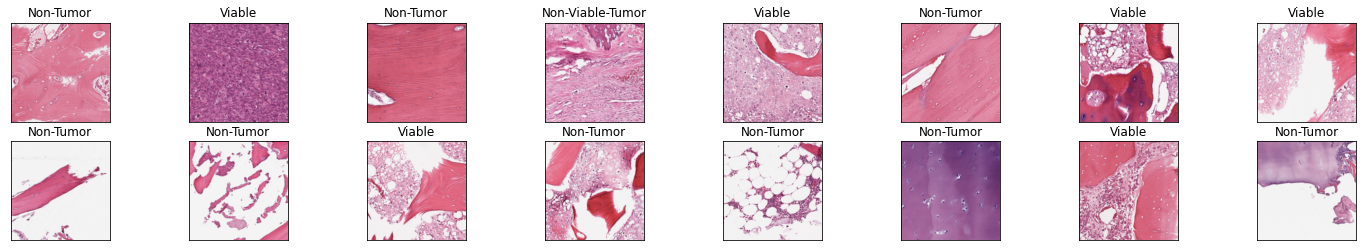

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
# Taking vgg16 model 
from torchvision import models
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# while taking 4096 features

# vgg16_model.classifier = vgg16_model.classifier[:-1] # vgg16_model.classifier is nn.Sequential block.
# vgg16_model.classifier = vgg16_model.classifier[:-1]

# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# change the number of classes  
# We have taken 3 output features as we have 3 classes images 
vgg16.classifier[2] = nn.Dropout(p= 0.5, inplace= False)
vgg16.classifier[3] = nn.Linear(4096, 1024)
vgg16.classifier[6] = nn.Linear(1024, 1024)
vgg16.classifier[5] = nn.Dropout(p= 0.3, inplace= False)
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
model = vgg16

In [ ]:
# converting model to GPU
if torch.cuda.is_available():
  model.cuda()

In [ ]:
from torchvision import models
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Training Model 

In [ ]:
# import torch.optim as optim
# # optimizer
# optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9 ) #weight_decay= 5e-4
# # optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001, betas= (0.9, 0.999), eps= 1e-8, weight_decay=0)
# # loss function
# criterion = nn.CrossEntropyLoss()

**We can train pre-trained model to increase our performance**

In [ ]:
# # train for some epochs 
# # number of epochs to train the model
# n_epochs = 10

# # using test set as validation set
# valid_loader = test_loader

# valid_loss_min = np.Inf # track change in validation loss

# valid_list= []  # stores validation losses
# train_list= []  # stores train losses

# valid_acc = [] # store validation accuracy
# train_acc = [] # store train accuracy

# for epoch in range(1, n_epochs+1):

#     # keep track of training, validation loss and accuracy
#     train_loss = 0.0
#     valid_loss = 0.0
#     train_corrects = 0
#     val_corrects = 0

#     # trianing the model
#     model.train()
#     for data, target in train_loader:
#         # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
#             data, target = data.cuda(), target.cuda()

#         optimizer.zero_grad()
#         output = model(data)
#         _,preds = torch.max(output, 1)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()*data.size(0)
#         train_corrects += torch.sum(preds == target.data)
        
          
#     # validate the model 
#     model.eval()
#     for data, target in valid_loader:
#         # move tensors to GPU if CUDA is available
#         if torch.cuda.is_available():
#             data, target = data.cuda(), target.cuda()
        
#         output = model(data)
#         _,preds = torch.max(output, 1)
#         loss = criterion(output, target)
#         valid_loss += loss.item()*data.size(0)
#         val_corrects += torch.sum(preds == target.data) 
    
#     # calculate average losses
#     train_loss = train_loss/len(train_loader.sampler)
#     valid_loss = valid_loss/len(valid_loader.sampler)
#     # calculate accuracy
#     t_acc = train_corrects/len(train_loader.sampler)
#     v_acc = val_corrects/len(valid_loader.sampler)
        
#     # print training/validation statistics 
#     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTrain Acc: {:4f} \tValidation Acc: {:4f}'.format(
#         epoch, train_loss, valid_loss, t_acc, v_acc))
    
#     # Using Schedular step
#     # scheduler.step()
    
#     # save model if validation loss has decreased
#     if valid_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#         valid_loss_min,
#         valid_loss))
#         torch.save(model.state_dict(), 'osteosercoma_vgg16.pt')
#         valid_loss_min = valid_loss
    
#     #storing train and validation looses
#     train_list.append(train_loss)
#     valid_list.append(valid_loss)
#     # storing train and validartion accuracy
#     train_acc.append(t_acc)
#     valid_acc.append(v_acc)

In [ ]:
# # plotting the training and validation loss
# plt.plot(train_list, label='Training loss')
# plt.plot(valid_list, label='Validation loss')
# plt.legend()
# plt.show()

In [ ]:
# train_acc = torch.tensor(train_acc, device= 'cpu')
# valid_acc = torch.tensor(valid_acc, device= 'cpu')

In [ ]:
# # plotting the training and validation accuracy
# plt.plot(train_acc.cpu(), label='Training Accuracy')
# plt.plot(valid_acc, label='Validation Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# # load best model
# vgg16.load_state_dict(torch.load('osteosercoma_vgg16.pt'))

# Making training and test features for ML Algorithm

In [ ]:
# feature extraction for training images

x_train = []
y_train = []
model.eval()
for data, target in train_loader:
  # move tensors to GPU if CUDA is available
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)
  x_train.append(output)

  if torch.cuda.is_available():
    target = torch.tensor(target, device= 'cpu')
  target = target.numpy()
  target = target.astype(int)
  y_train.append(target)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
# feature extraction for test images 

x_test = []
y_test = []
model.eval()
for data, target in test_loader:
  # move tensors to GPU if CUDA is available
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)
  x_test.append(output)

  if torch.cuda.is_available():
    target = torch.tensor(target, device= 'cpu')

  target = target.numpy()
  target = target.astype(int)
  y_test.append(target)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
# As we are getting data from dataloader, so data are inserted as batch size
# that's why we need to convert this into 1D list 
from itertools import chain
x_train_features = list(chain.from_iterable(x_train))
x_test_features = list(chain.from_iterable(x_test))

print("Total training features: ", len(x_train_features))
print("Total test features: ", len(x_test_features))

Total training features:  916
Total test features:  228


In [ ]:
# converting labels into one dimensional list 
y_train = list(chain.from_iterable(y_train))
y_test = list(chain.from_iterable(y_test))

print("Total training labels: ", len(y_train))
print("Total test labels: ", len(y_test))

Total training labels:  916
Total test labels:  228


In [ ]:
for i in range(len(x_train_features)):
  # x_train_features[i] = x_train_features[i].numpy()
  if torch.cuda.is_available():
    x_train_features[i] = x_train_features[i].cpu().detach().numpy()   # if use GPU
  
  # x_train_features[i] = x_train_features[i].detach().numpy()   # if use GPU
  
# converting list to numpy array
x_train_features = np.array(x_train_features)
print("Shape of training features: ",x_train_features.shape)

Shape of training features:  (916, 1024)


In [ ]:
# x_test_features

In [ ]:
for i in range(len(x_test_features)):
  # x_test_features[i] = x_test_features[i].numpy()
  if torch.cuda.is_available():
    x_test_features[i] = x_test_features[i].cpu().detach().numpy()

  # x_test_features[i] = x_test_features[i].detach().numpy()

# converting list to numpy array
x_test_features = np.array(x_test_features)
print("Shape of test features: ",x_test_features.shape)

Shape of test features:  (228, 1024)


In [ ]:
#Convert label lists to arrays                
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Shape of training labels: ", y_train.shape)
print("Shape of test labels: ", y_test.shape)

Shape of training labels:  (916,)
Shape of test labels:  (228,)


# ROC-AUC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
train_X = x_train_features
train_Y = y_train
test_X = x_test_features
test_Y = y_test

In [ ]:
# label binarize 
from sklearn.preprocessing import label_binarize
# for train labels 
train_Y = label_binarize(train_Y, classes=[0, 1, 2])
n_classes = train_Y.shape[1]
print(f"Number of class: {n_classes}")

# for test labels 
test_Y = label_binarize(test_Y, classes=[0,1,2])
n_classes = test_Y.shape[1]
print(f"Number of class: {n_classes}")

Number of class: 3
Number of class: 3


In [ ]:
# XGBoost
import xgboost as xgb

# Learn to predict each class against the other
xg_classifier = OneVsRestClassifier(
    xgb.XGBClassifier(learning_rate= 0.006)
)
y_score = xg_classifier.fit(train_X, train_Y).predict_proba(test_X)

 # Compute ROC curve and ROC area for each class
xg_fpr = dict()
xg_tpr = dict()
xg_roc_auc = dict()
for i in range(n_classes):
    xg_fpr[i], xg_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    xg_roc_auc[i] = auc(xg_fpr[i], xg_tpr[i])

# Compute micro-average ROC curve and ROC area
xg_fpr["micro"], xg_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
xg_roc_auc["micro"] = auc(xg_fpr["micro"], xg_tpr["micro"])

# getting micro average 
print(f"Micro average: {xg_roc_auc['micro']}")

# macro average 
# First aggregate all false positive rates
xg_all_fpr = np.unique(np.concatenate([xg_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
xg_mean_tpr = np.zeros_like(xg_all_fpr)
for i in range(n_classes):
    xg_mean_tpr += np.interp(xg_all_fpr, xg_fpr[i], xg_tpr[i])

# Finally average it and compute AUC
xg_mean_tpr /= n_classes

xg_fpr["macro"] = xg_all_fpr
xg_tpr["macro"] = xg_mean_tpr
xg_roc_auc["macro"] = auc(xg_fpr["macro"], xg_tpr["macro"])

print(f"Macro average ROC: {xg_roc_auc['macro']}")

Micro average: 0.9211151508156356
Macro average ROC: 0.9144452434045583


In [ ]:
# For Decision tree
from sklearn.tree import DecisionTreeClassifier

# Learn to predict each class against the other
dt_classifier = OneVsRestClassifier(
    DecisionTreeClassifier(max_depth =7, random_state = 42)
)
y_score = dt_classifier.fit(train_X, train_Y).predict_proba(test_X)

 # Compute ROC curve and ROC area for each class
dt_fpr = dict()
dt_tpr = dict()
dt_roc_auc = dict()
for i in range(n_classes):
    dt_fpr[i], dt_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    dt_roc_auc[i] = auc(dt_fpr[i], dt_tpr[i])

# Compute micro-average ROC curve and ROC area
dt_fpr["micro"], dt_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
dt_roc_auc["micro"] = auc(dt_fpr["micro"], dt_tpr["micro"])

# getting micro average 
print(f"Micro average: {dt_roc_auc['micro']}")

# macro average 
# First aggregate all false positive rates
dt_all_fpr = np.unique(np.concatenate([dt_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
dt_mean_tpr = np.zeros_like(dt_all_fpr)
for i in range(n_classes):
    dt_mean_tpr += np.interp(dt_all_fpr, dt_fpr[i], dt_tpr[i])

# Finally average it and compute AUC
dt_mean_tpr /= n_classes

dt_fpr["macro"] = dt_all_fpr
dt_tpr["macro"] = dt_mean_tpr
dt_roc_auc["macro"] = auc(dt_fpr["macro"], dt_tpr["macro"])

print(f"Macro average ROC: {dt_roc_auc['macro']}")

Micro average: 0.7685105032317637
Macro average ROC: 0.7471142033764362


In [ ]:
# for Random Forest 
# importing random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(
    RandomForestClassifier(n_estimators = 64, criterion = 'gini', ccp_alpha=0.05, random_state = 42)
)
y_score = rf_classifier.fit(train_X, train_Y).predict_proba(test_X)

 # Compute ROC curve and ROC area for each class
rf_fpr = dict()
rf_tpr = dict()
rf_roc_auc = dict()
for i in range(n_classes):
    rf_fpr[i], rf_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    rf_roc_auc[i] = auc(rf_fpr[i], rf_tpr[i])

# Compute micro-average ROC curve and ROC area
rf_fpr["micro"], rf_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
rf_roc_auc["micro"] = auc(rf_fpr["micro"], rf_tpr["micro"])

# getting micro average 
print(f"Micro average: {rf_roc_auc['micro']}")

# macro average 
# First aggregate all false positive rates
rf_all_fpr = np.unique(np.concatenate([rf_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
rf_mean_tpr = np.zeros_like(rf_all_fpr)
for i in range(n_classes):
    rf_mean_tpr += np.interp(rf_all_fpr, rf_fpr[i], rf_tpr[i])

# Finally average it and compute AUC
rf_mean_tpr /= n_classes

rf_fpr["macro"] = rf_all_fpr
rf_tpr["macro"] = rf_mean_tpr
rf_roc_auc["macro"] = auc(rf_fpr["macro"], rf_tpr["macro"])

print(f"Macro average ROC: {rf_roc_auc['macro']}")

Micro average: 0.8772699292089874
Macro average ROC: 0.9277764214330906


In [ ]:
# For LGBM 
from lightgbm import LGBMClassifier

# Learn to predict each class against the other
lgbm_classifier = OneVsRestClassifier(
    LGBMClassifier(learning_rate= 0.005)
)
y_score = lgbm_classifier.fit(train_X, train_Y).predict_proba(test_X)

 # Compute ROC curve and ROC area for each class
lgbm_fpr = dict()
lgbm_tpr = dict()
lgbm_roc_auc = dict()
for i in range(n_classes):
    lgbm_fpr[i], lgbm_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    lgbm_roc_auc[i] = auc(lgbm_fpr[i], lgbm_tpr[i])

# Compute micro-average ROC curve and ROC area
lgbm_fpr["micro"], lgbm_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
lgbm_roc_auc["micro"] = auc(lgbm_fpr["micro"], lgbm_tpr["micro"])

# getting micro average 
print(f"Micro average: {lgbm_roc_auc['micro']}")

# macro average 
# First aggregate all false positive rates
lgbm_all_fpr = np.unique(np.concatenate([lgbm_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
lgbm_mean_tpr = np.zeros_like(lgbm_all_fpr)
for i in range(n_classes):
    lgbm_mean_tpr += np.interp(lgbm_all_fpr, lgbm_fpr[i], lgbm_tpr[i])

# Finally average it and compute AUC
lgbm_mean_tpr /= n_classes

lgbm_fpr["macro"] = lgbm_all_fpr
lgbm_tpr["macro"] = lgbm_mean_tpr
lgbm_roc_auc["macro"] = auc(lgbm_fpr["macro"], lgbm_tpr["macro"])

print(f"Macro average ROC: {lgbm_roc_auc['macro']}")

Micro average: 0.9013446445060018
Macro average ROC: 0.9277114513214549


In [ ]:
from sklearn.neural_network import MLPClassifier
# Learn to predict each class against the other
mlp_classifier = OneVsRestClassifier(
    MLPClassifier(random_state=1, max_iter=200)
)
y_score = mlp_classifier.fit(train_X, train_Y).predict_proba(test_X)

# Compute ROC curve and ROC area for each class
mlp_fpr = dict()
mlp_tpr = dict()
mlp_roc_auc = dict()
for i in range(n_classes):
    mlp_fpr[i], mlp_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    mlp_roc_auc[i] = auc(mlp_fpr[i], mlp_tpr[i])

# Compute micro-average ROC curve and ROC area
mlp_fpr["micro"], mlp_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
mlp_roc_auc["micro"] = auc(mlp_fpr["micro"], mlp_tpr["micro"])

print(f"Micro average: {mlp_roc_auc['micro']}")

# First aggregate all false positive rates
mlp_all_fpr = np.unique(np.concatenate([mlp_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mlp_mean_tpr = np.zeros_like(mlp_all_fpr)
for i in range(n_classes):
    mlp_mean_tpr += np.interp(mlp_all_fpr, mlp_fpr[i], mlp_tpr[i])

# Finally average it and compute AUC
mlp_mean_tpr /= n_classes

mlp_fpr["macro"] = mlp_all_fpr
mlp_tpr["macro"] = mlp_mean_tpr
mlp_roc_auc["macro"] = auc(mlp_fpr["macro"], mlp_tpr["macro"])

print(f"ROC Macro: {mlp_roc_auc['macro']}")
print(f"Micro average: {mlp_roc_auc['micro']}")

Micro average: 0.9743574946137273
ROC Macro: 0.9734020860502375
Micro average: 0.9743574946137273


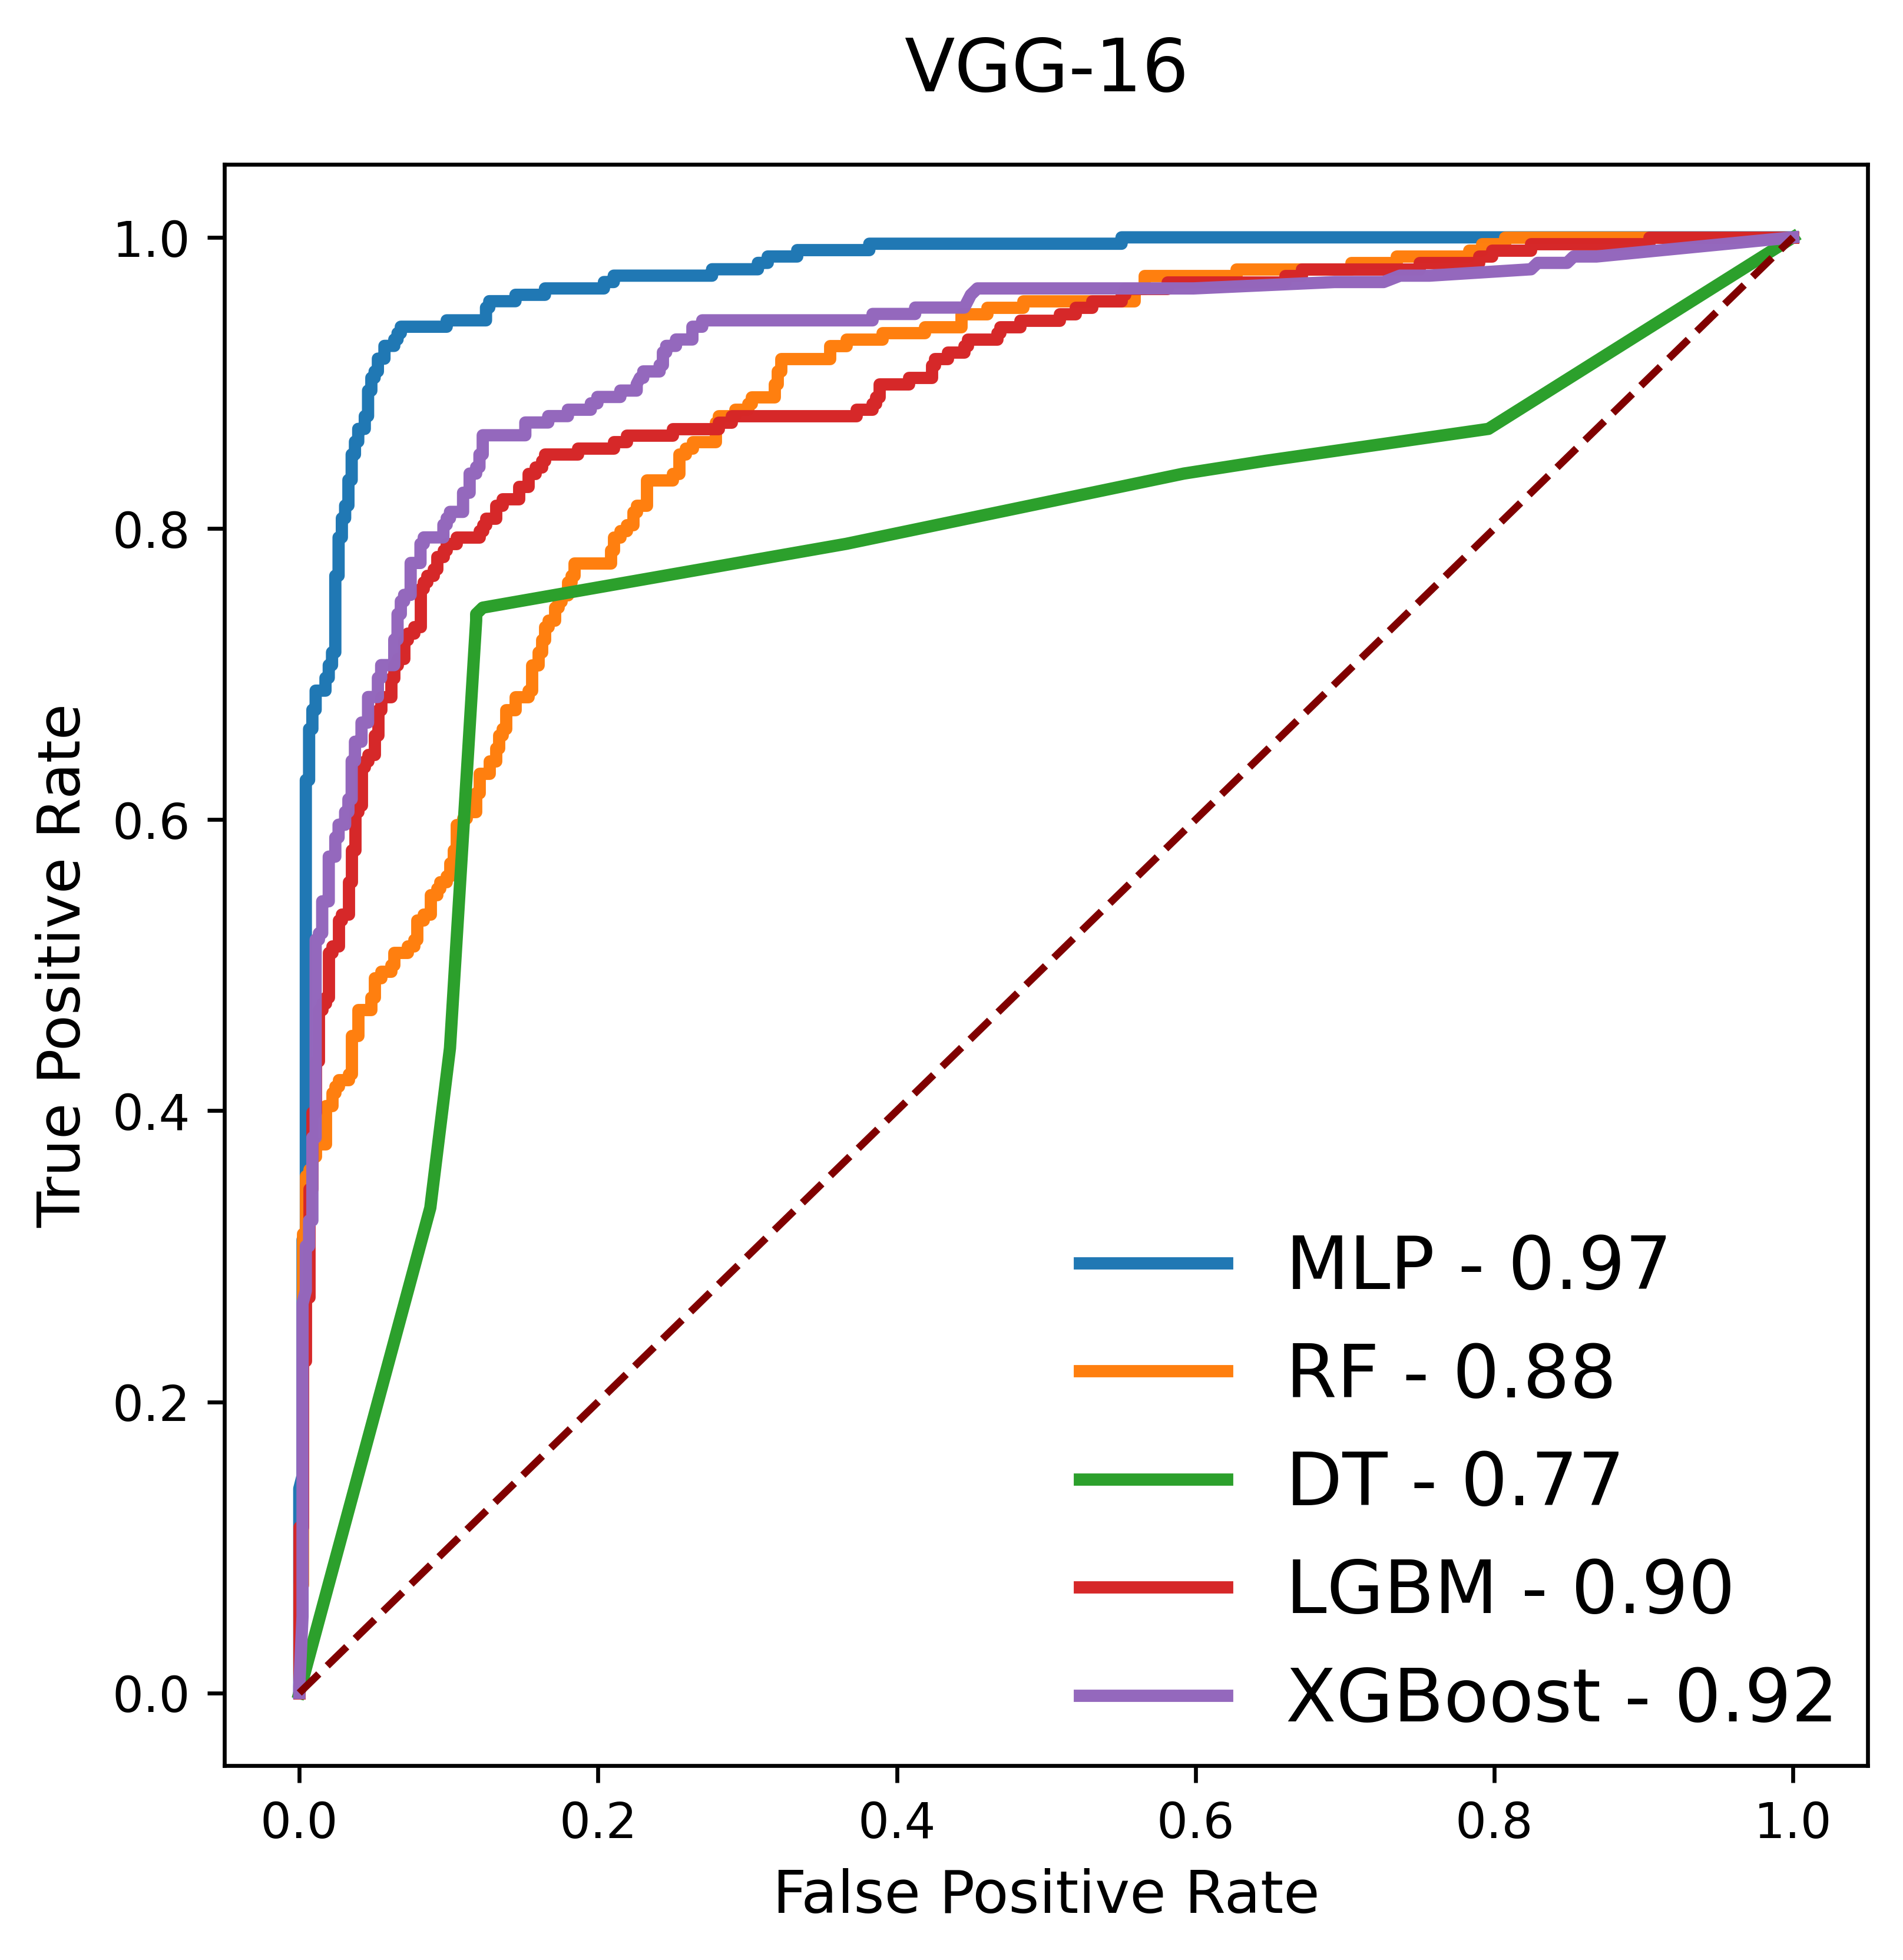

In [ ]:
# Plot all ROC curves
plt_1 = plt.figure(figsize=(6,6))
plt.plot(
    mlp_fpr["micro"],
    mlp_tpr["micro"],
    label="MLP - {0:0.2f}".format(mlp_roc_auc["micro"]),
    
    alpha = 2,
    linewidth=2.5,
)

plt.plot(
    rf_fpr["micro"],
    rf_tpr["micro"],
    label="RF - {0:0.2f}".format(rf_roc_auc["micro"]),
    
    alpha = 2,
    linewidth=2.5,
)

plt.plot(
    dt_fpr["micro"],
    dt_tpr["micro"],
    label="DT - {0:0.2f}".format(dt_roc_auc["micro"]),
    
    alpha = 1,
    linewidth=2.5,
)

plt.plot(
    lgbm_fpr["micro"],
    lgbm_tpr["micro"],
    label="LGBM - {0:0.2f}".format(lgbm_roc_auc["micro"]),
    
    alpha = 2,
    linewidth=2.5,
)
plt.plot(
    xg_fpr['micro'],
    xg_tpr['micro'],
    
    alpha = 2, 
    linewidth=2.5,
    label="XGBoost - %0.2f" % xg_roc_auc['micro'],
)

# change resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

plt.plot([0, 1], [0, 1], "k--", lw=1.5, color='maroon')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.title("VGG-16", pad= 15, fontsize= 15)
plt.legend(loc="lower right", frameon=False, fontsize=15,borderaxespad=0.)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/vgg-16.png")
plt.show()

# XGBOOST

In [ ]:
#XGBOOST
import xgboost as xgb
# model = xgb.XGBClassifier()
model = xgb.XGBClassifier(learning_rate= 0.006)
model.fit(x_train_features, y_train) #For sklearn no one hot encoding

XGBClassifier(learning_rate=0.006, objective='multi:softprob')

In [ ]:
#Now predict using the trained RF model. 
prediction = model.predict(x_test_features)

In [ ]:
prediction

array([0, 1, 1, 2, 0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 2,
       0, 0, 2, 2, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 2,
       2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 0, 0,
       0, 0, 2, 1, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1,
       0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 2, 1, 2, 0, 0, 1, 2, 2, 1,
       2, 1, 2, 1, 0, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2,
       1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 0, 2, 0, 1, 1, 2, 1, 0, 0, 0,
       2, 1, 2, 2, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 1, 2, 2,
       0, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 1, 2, 2, 0, 2, 1, 2, 0, 2, 0, 0,
       2, 2, 2, 0, 0, 2, 0, 2])

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, prediction)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.811


**Matthews Correlation Coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, prediction)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.705


**ROC AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

clf = xgb.XGBClassifier(learning_rate= 0.006).fit(x_train_features, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.927


**Confusion Matrix**

In [ ]:
# Function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize= False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
        title = "Normalized Confusion Matrix"
    else:
        # print('Confusion matrix, without normalization')
        title = "Confusion Matrix"

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

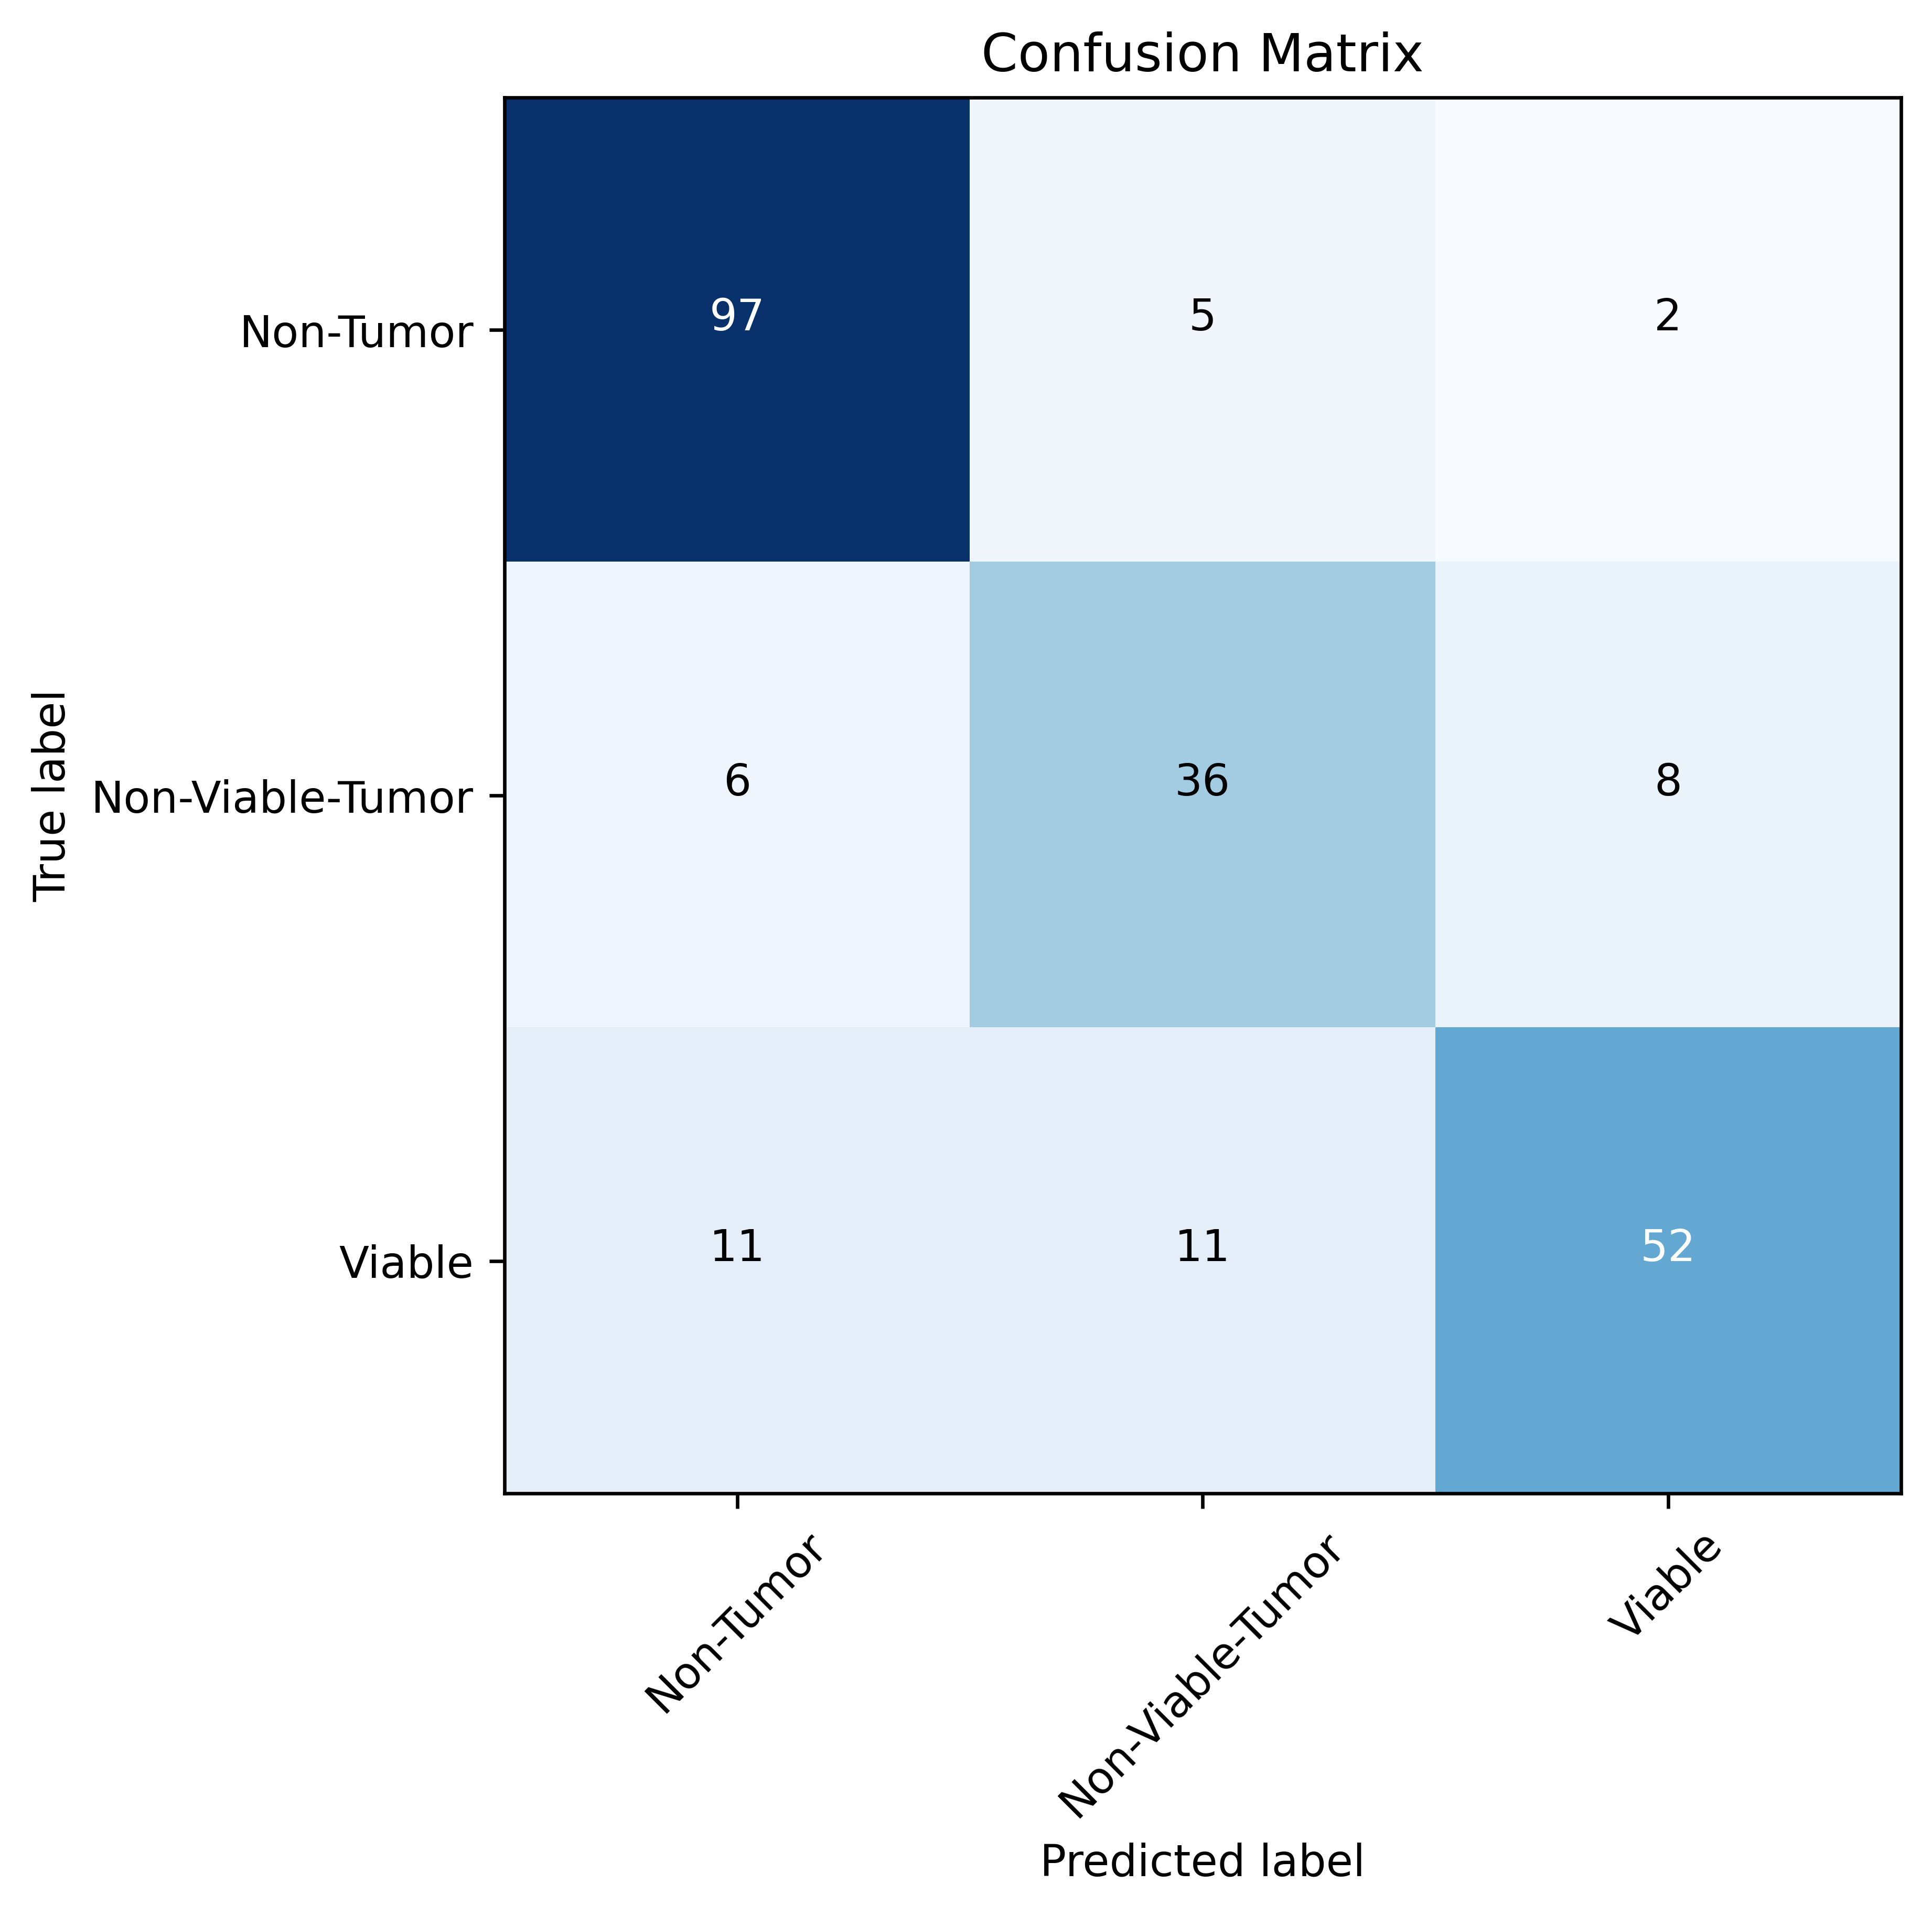

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, prediction)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

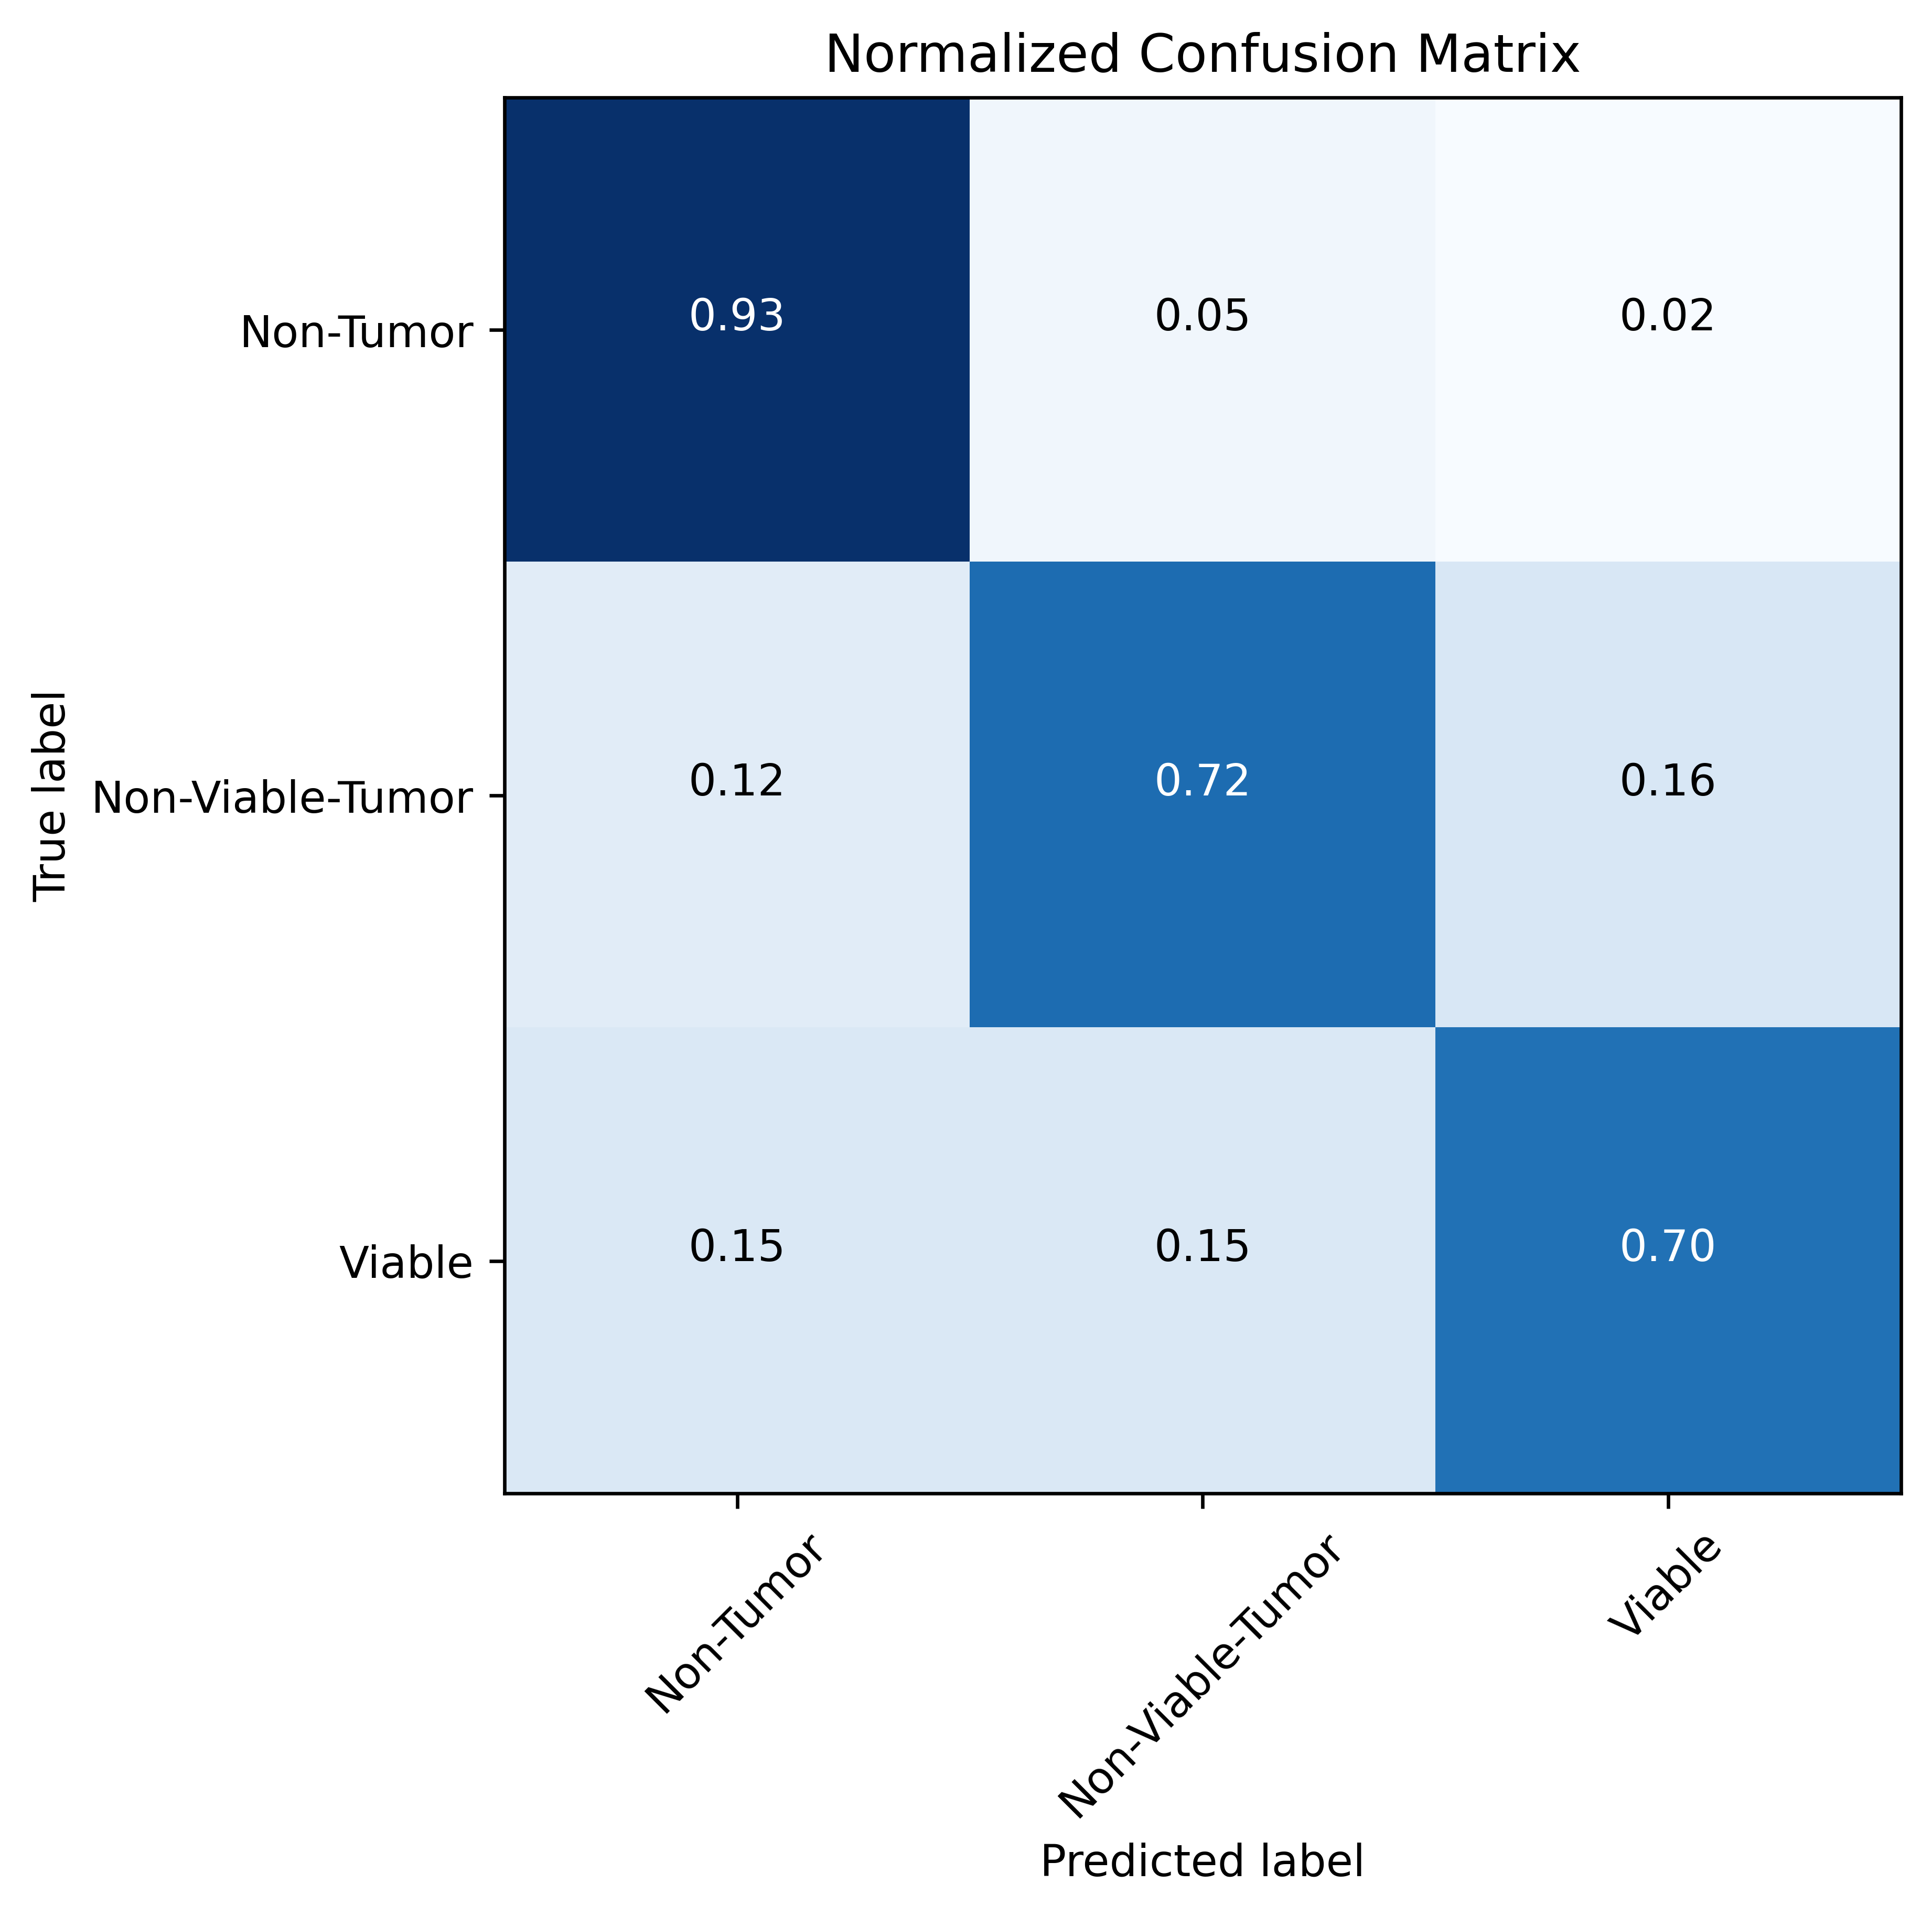

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

In [ ]:
# Normalizing confusion matrix
print(np.sum(conf_matrix, axis= 1))
print("\nAfeter reshaping: \n")
print(np.sum(conf_matrix, axis= 1).reshape(-1, 1))

[104  50  74]

Afeter reshaping: 

[[104]
 [ 50]
 [ 74]]


In [ ]:
# function to measure TP, FP, TN, FN

def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

class_id = set(y_test).union(set(prediction))
print(class_id)
c, tp, fp, tn, fn = perf_measure(y_test, prediction)
print("TP: ", tp)
print("FP: ", fp)
print("TN: ", tn)
print("FN: ", fn)

{0, 1, 2}
TP:  [97, 36, 52]
FP:  [17, 16, 10]
TN:  [88, 149, 133]
FN:  [26, 27, 33]


In [ ]:
# getting precision
# if we want to get precision then we need to follow this equation,
# precision= TP/(TP + FP)
# precision for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]
print(tp_0, fp_0, tn_0, fn_0)
p_0 = tp_0 /(tp_0 + fp_0)
print('precision for class 0: ',p_0)

tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]
print(tp_1, fp_1, tn_1, fn_1)
p_1 = tp_1 /(tp_1 + fp_1)
print('precision for class 1: ', p_1)

tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]
print(tp_2, fp_2, tn_2, fn_2)
p_2 = tp_2 /(tp_2 + fp_2)
print('precision for class 2: ', p_2)

97 17 88 26
precision for class 0:  0.8508771929824561
36 16 149 27
precision for class 1:  0.6923076923076923
52 10 133 33
precision for class 2:  0.8387096774193549


In [ ]:
# Normalizing confusion matrix
print(np.round(conf_matrix/ np.sum(conf_matrix, axis= 1).reshape(-1, 1), 2))

[[0.93 0.05 0.02]
 [0.12 0.72 0.16]
 [0.15 0.15 0.7 ]]


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       104
           1       0.69      0.72      0.71        50
           2       0.84      0.70      0.76        74

    accuracy                           0.81       228
   macro avg       0.79      0.79      0.79       228
weighted avg       0.81      0.81      0.81       228



**calculating precision, recall(sensitivity), specificity by formula**:

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, prediction)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.851     	      0.789      	   0.838   
  1   Non-Viable-Tumor     0.692     	      0.571      	   0.903   
  2        Viable          0.839      	      0.612      	    0.93   


**specificity and sensitivity**

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2]:
     prec,recall,_,_ = precision_recall_fscore_support(y_test==l,
                                                  prediction==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

data = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
# data['class_name'] = classes
df2 = data.assign(class_name=['Non-Tumor', 'Non-Viable-Tumor', 'Viable'])
df2

,class,sensitivity,specificity,class_name
0,0,0.862903,0.932692,Non-Tumor
1,1,0.910112,0.720000,Non-Viable-Tumor
2,2,0.935065,0.702703,Viable


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# defining decision tree classifier 
# d_tree_clf = DecisionTreeClassifier(random_state=0)
d_tree_clf = DecisionTreeClassifier(max_depth =7, random_state = 42)
d_tree_clf.fit(x_train_features, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [ ]:
# predict through test data
d_tree_pred = d_tree_clf.predict(x_test_features)

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, d_tree_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.68


**Matthews Correlation Coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, d_tree_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.497


**ROC AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, d_tree_clf.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.693


**confusion matrix**

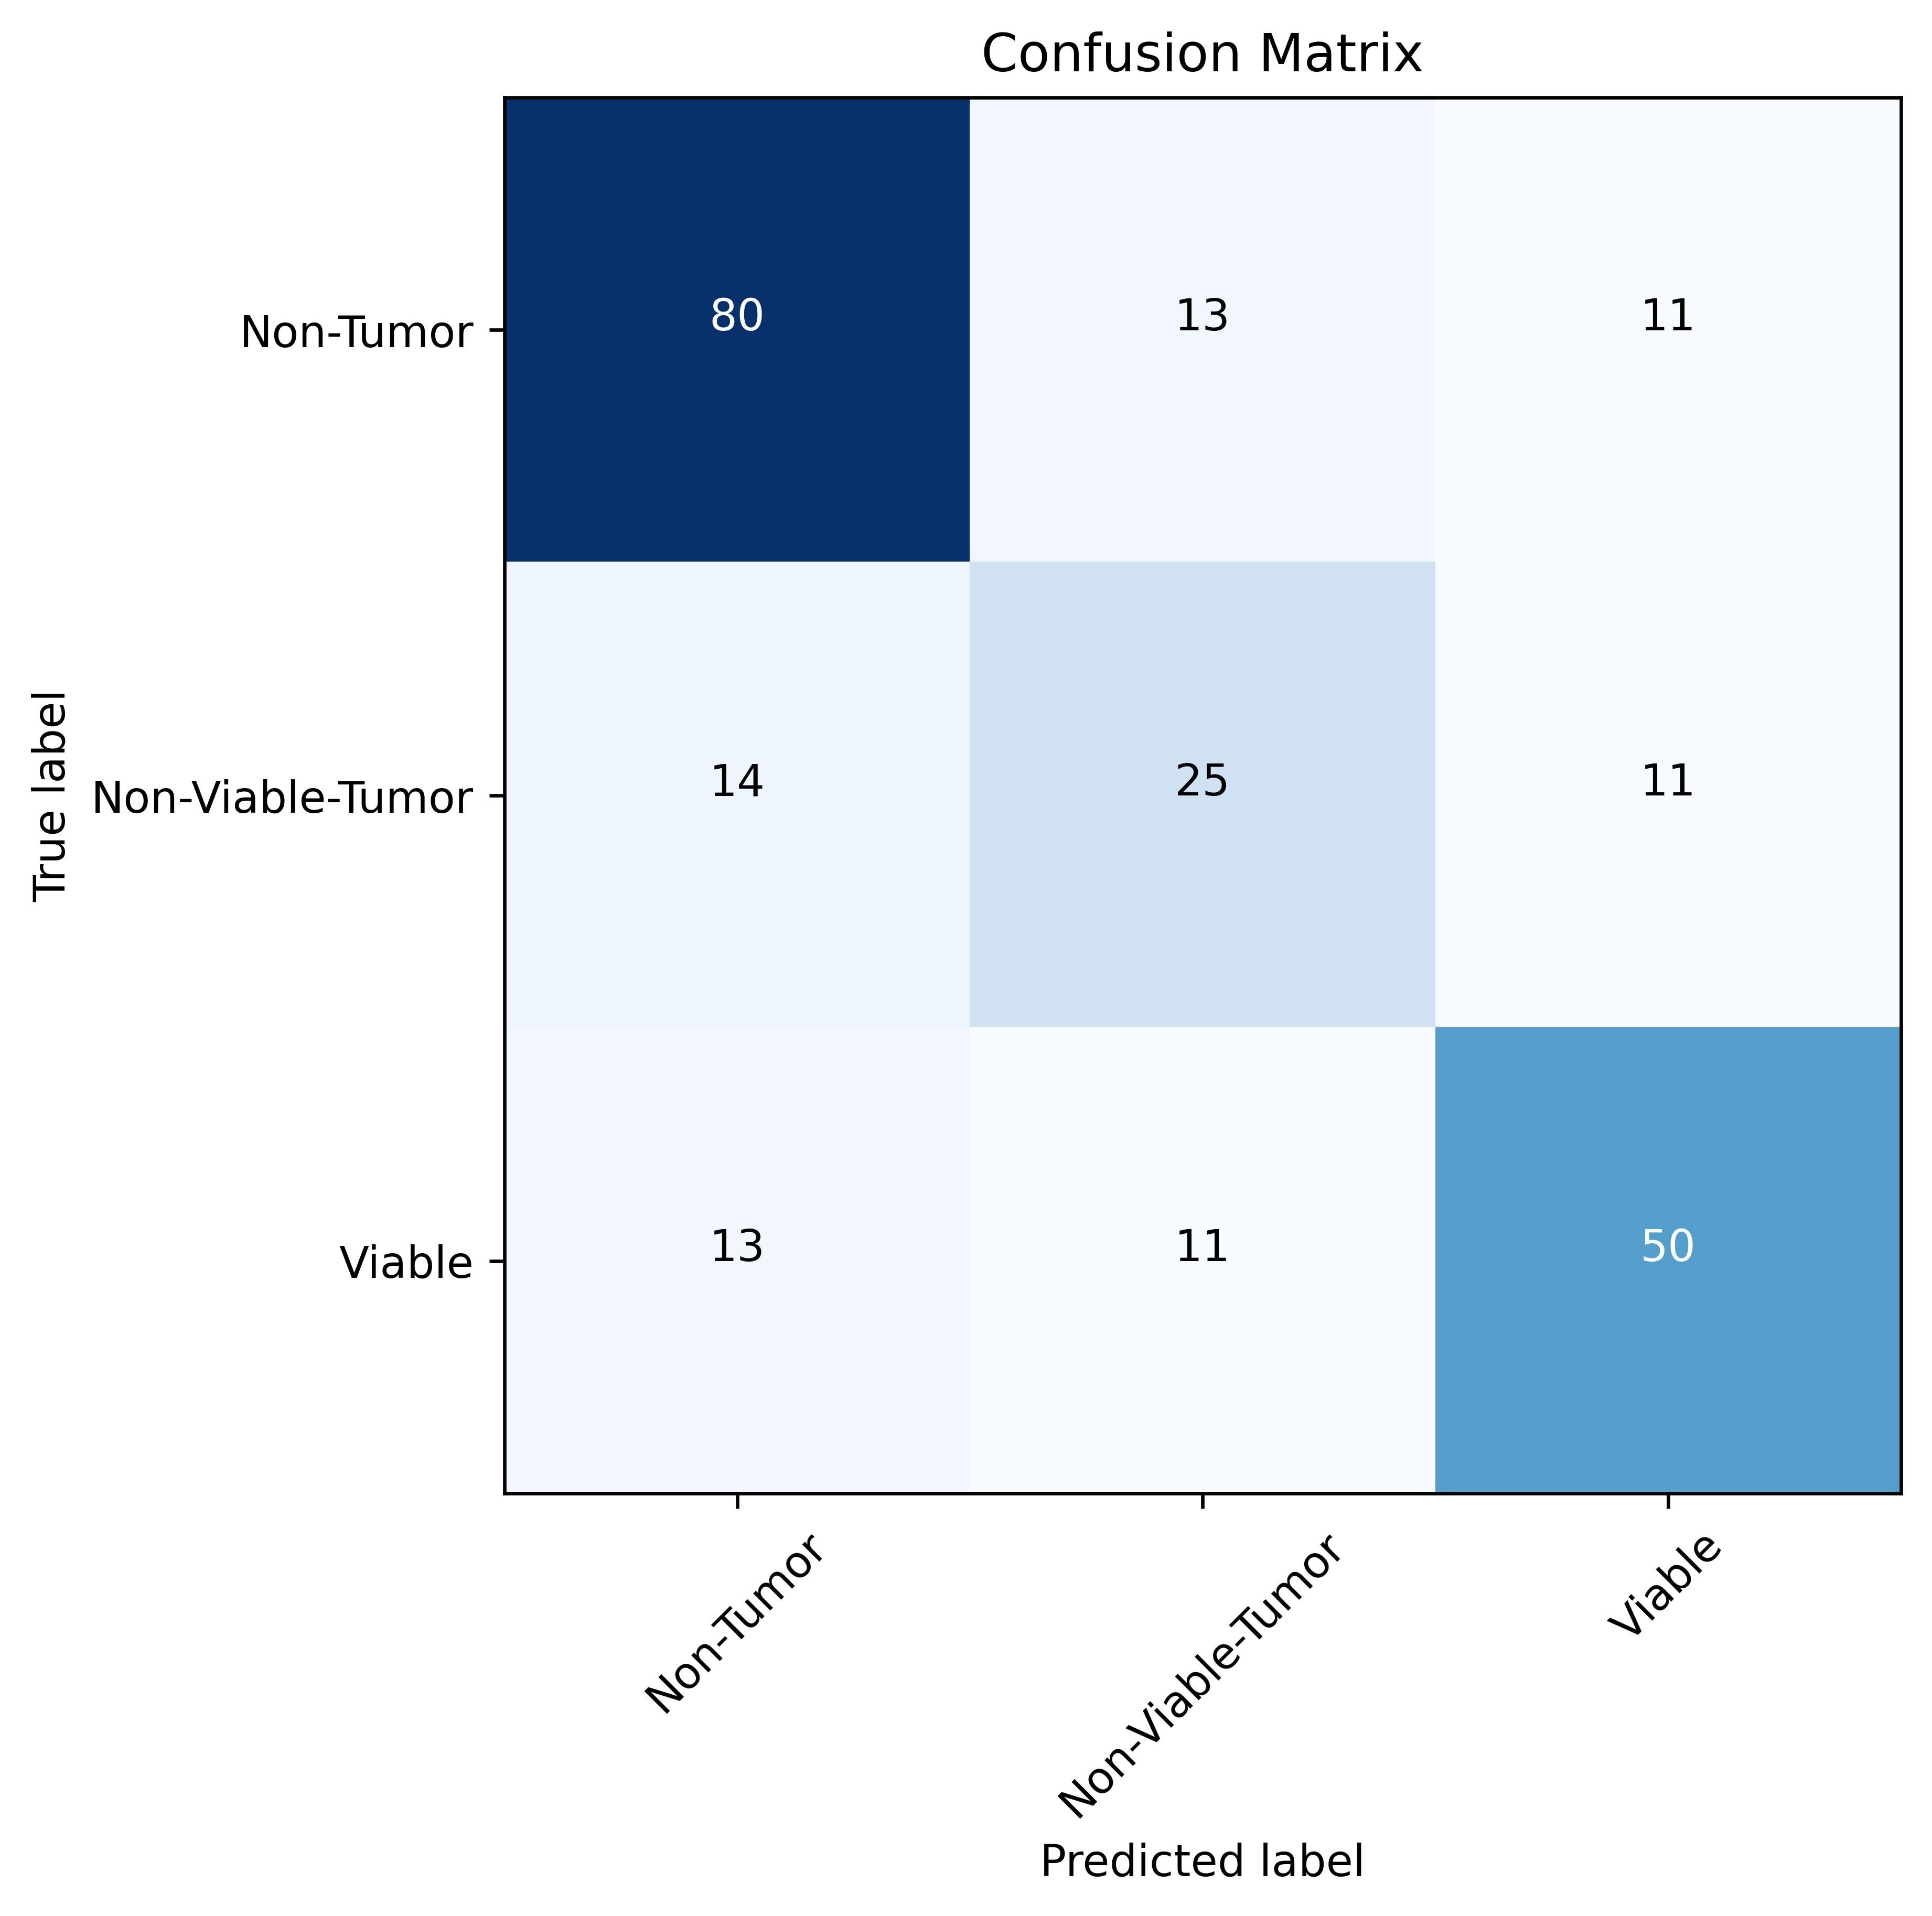

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, d_tree_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

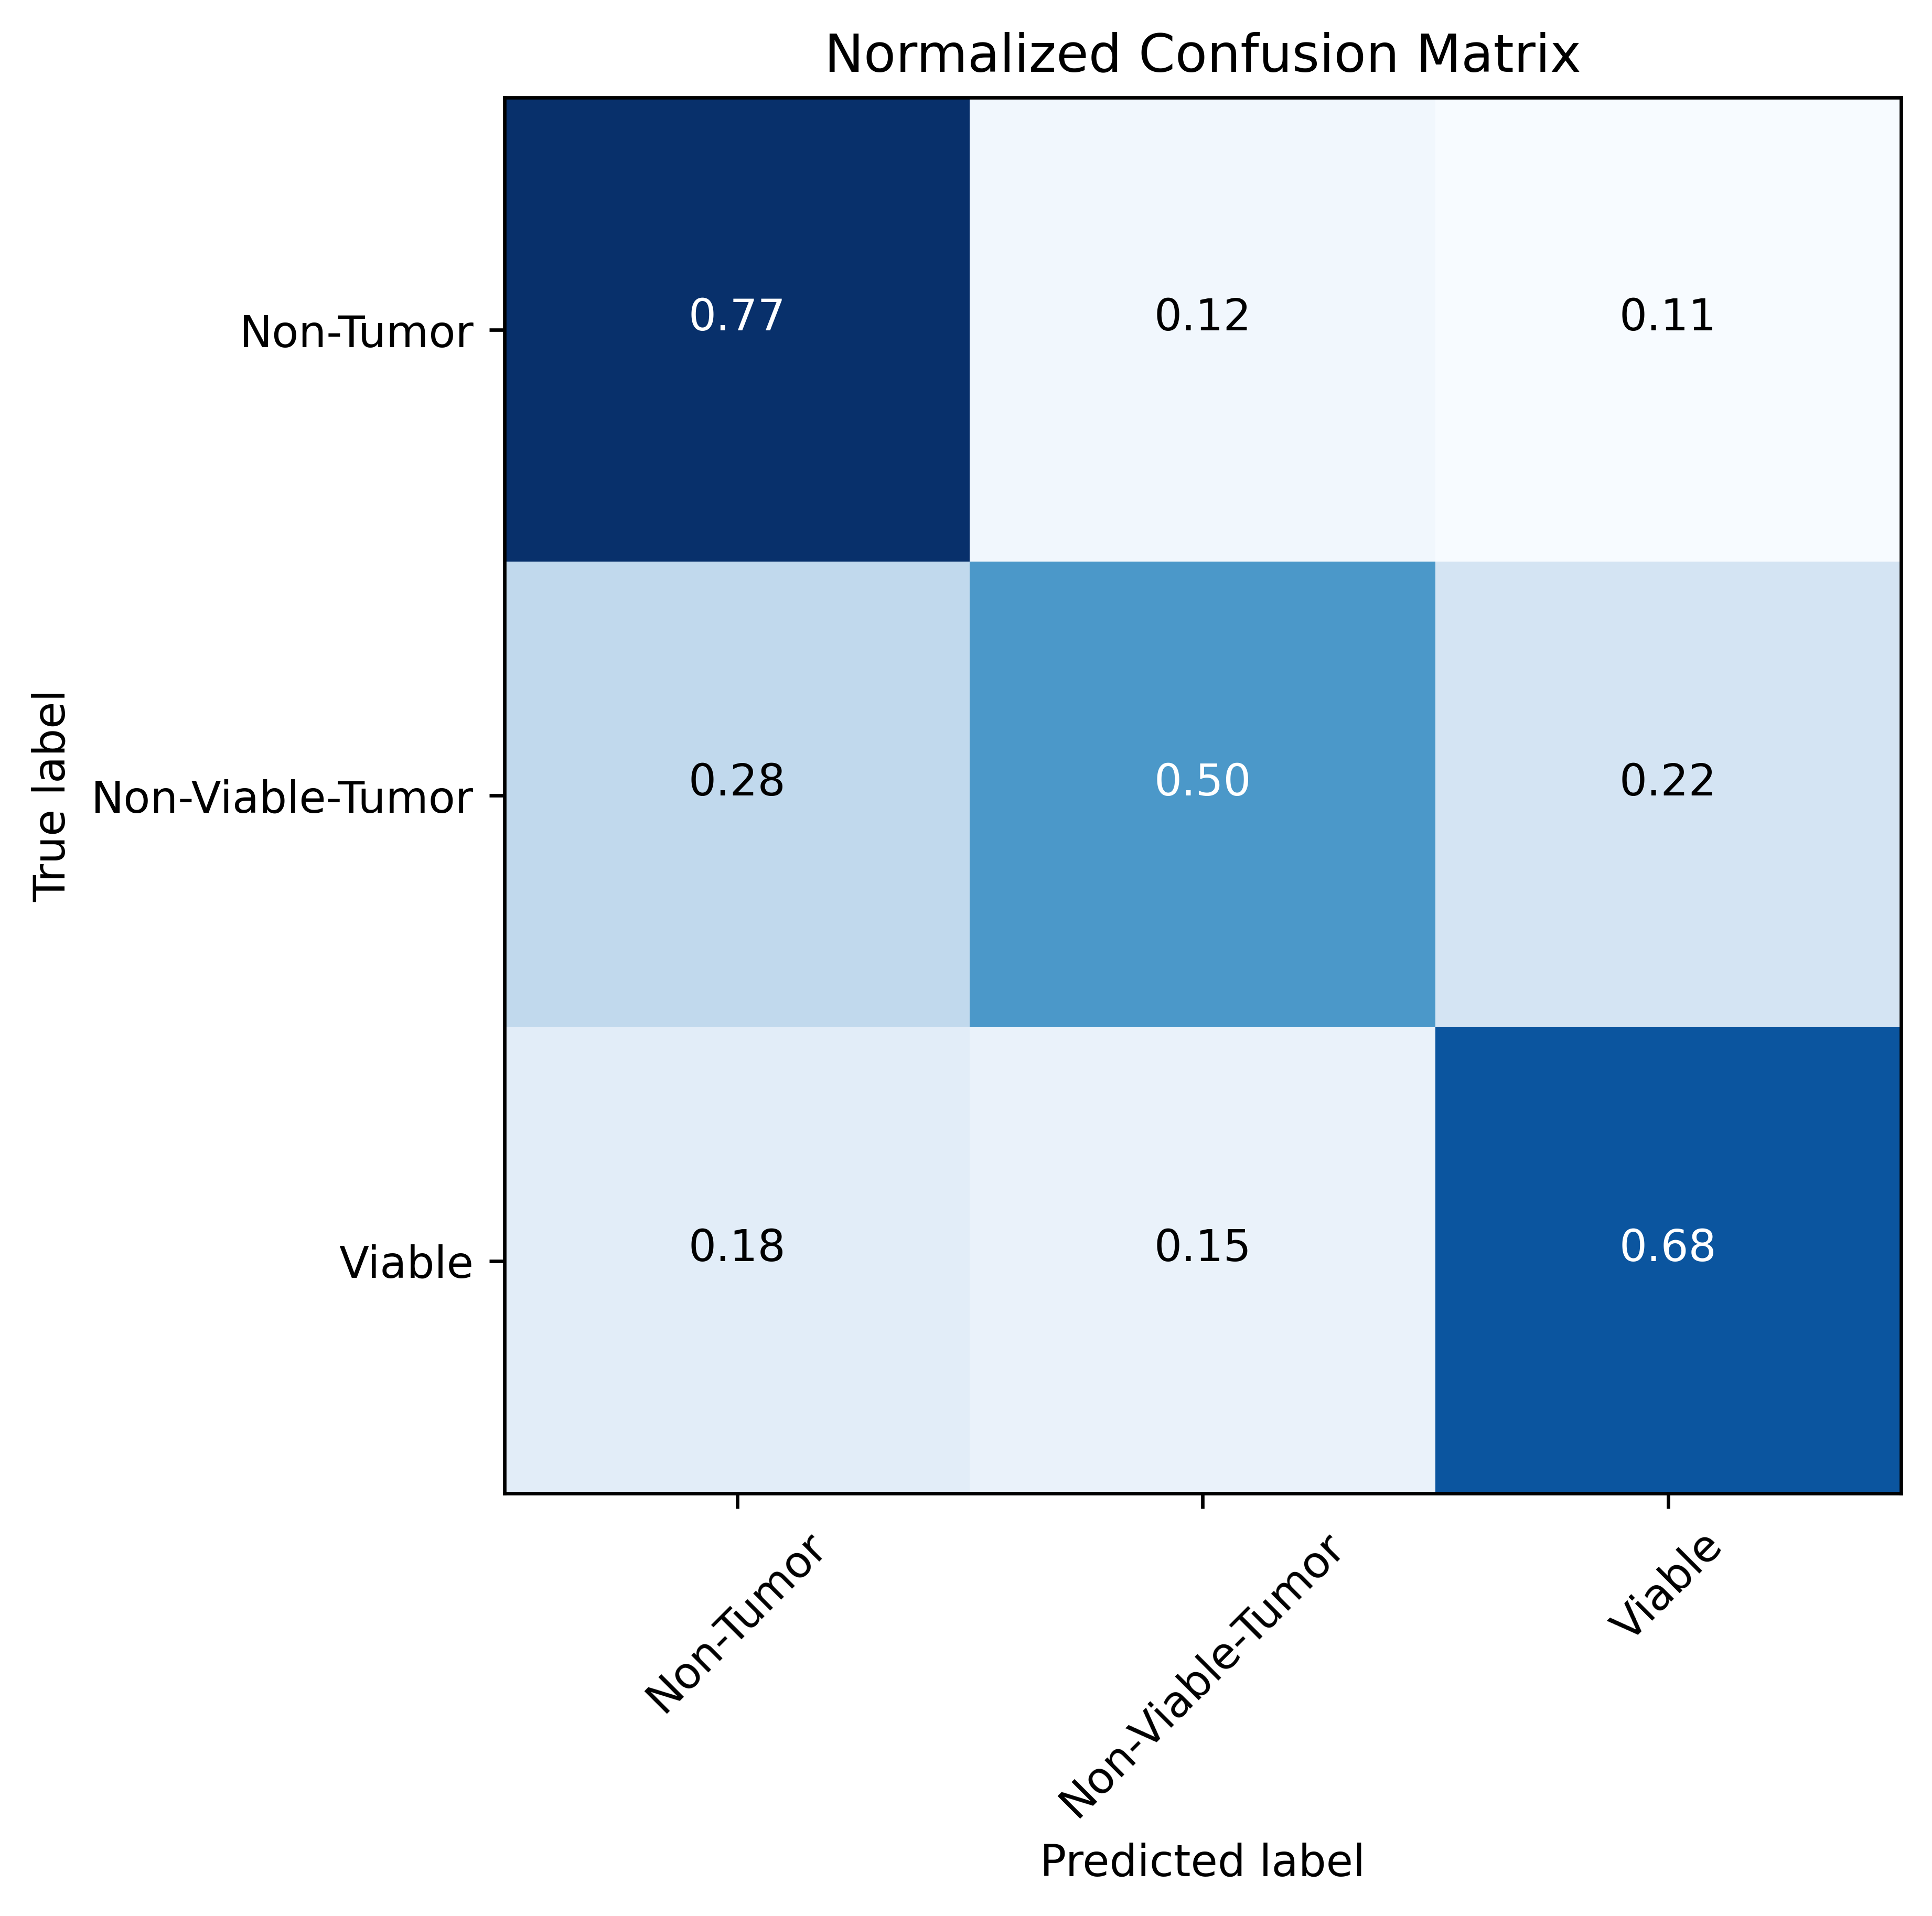

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**classification report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, d_tree_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       104
           1       0.51      0.50      0.51        50
           2       0.69      0.68      0.68        74

    accuracy                           0.68       228
   macro avg       0.65      0.65      0.65       228
weighted avg       0.68      0.68      0.68       228



**calculating precision, recall(sensitivity), specificity by formula**

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, d_tree_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.748     	      0.635      	   0.735   
  1   Non-Viable-Tumor      0.51     	      0.338      	   0.844   
  2        Viable          0.694      	      0.495      	   0.827   


# Random Forest

In [ ]:
# importing random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Fitting Random Forest Classification to the Training set
# rf_classifier = RandomForestClassifier(n_estimators = 64, criterion = 'entropy', random_state = 42)
rf_classifier = RandomForestClassifier(n_estimators = 64, criterion = 'gini', ccp_alpha=0.05, random_state = 42)
rf_classifier.fit(x_train_features, y_train)

RandomForestClassifier(ccp_alpha=0.05, n_estimators=64, random_state=42)

In [ ]:
# prediciting on test data
rf_pred = rf_classifier.predict(x_test_features)

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, rf_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.627


**Matthews Correlation Coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, rf_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.437


**ROC-AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.909


**confusion matrix**

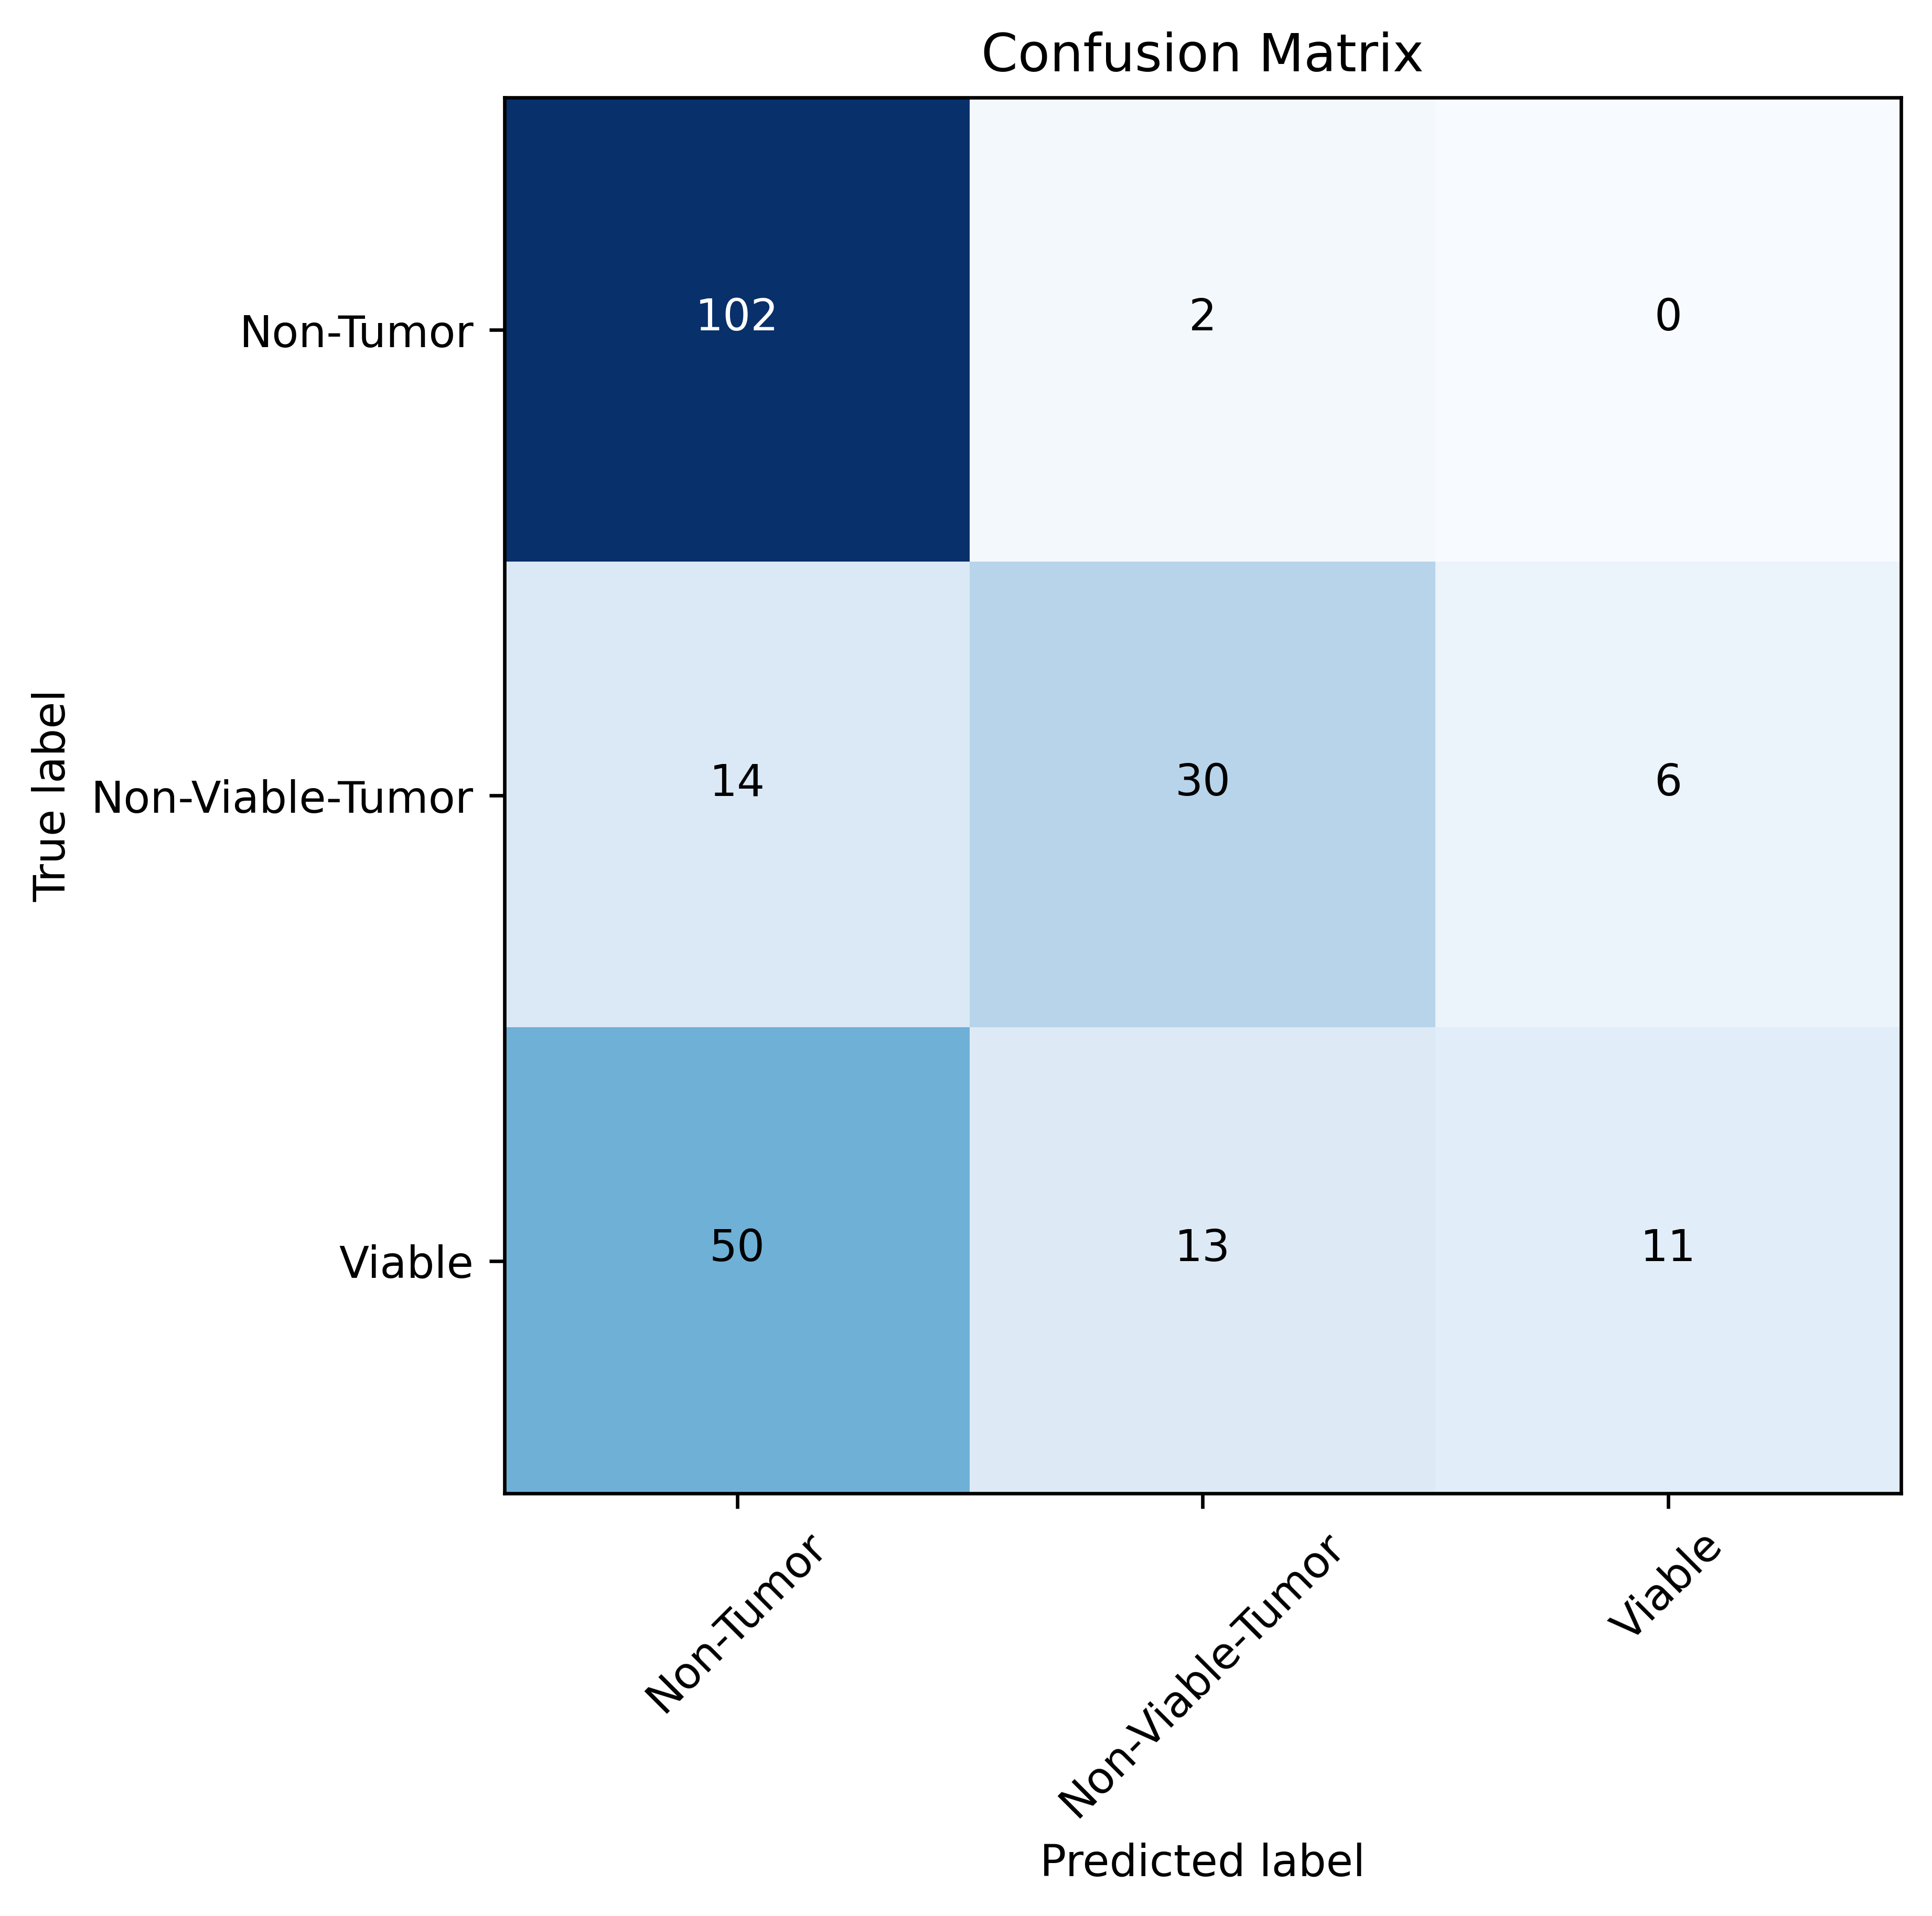

In [ ]:
# getting confusion matrix 
conf_matrix = confusion_matrix(y_test, rf_pred)

# plotting confusion matrix without normalization
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

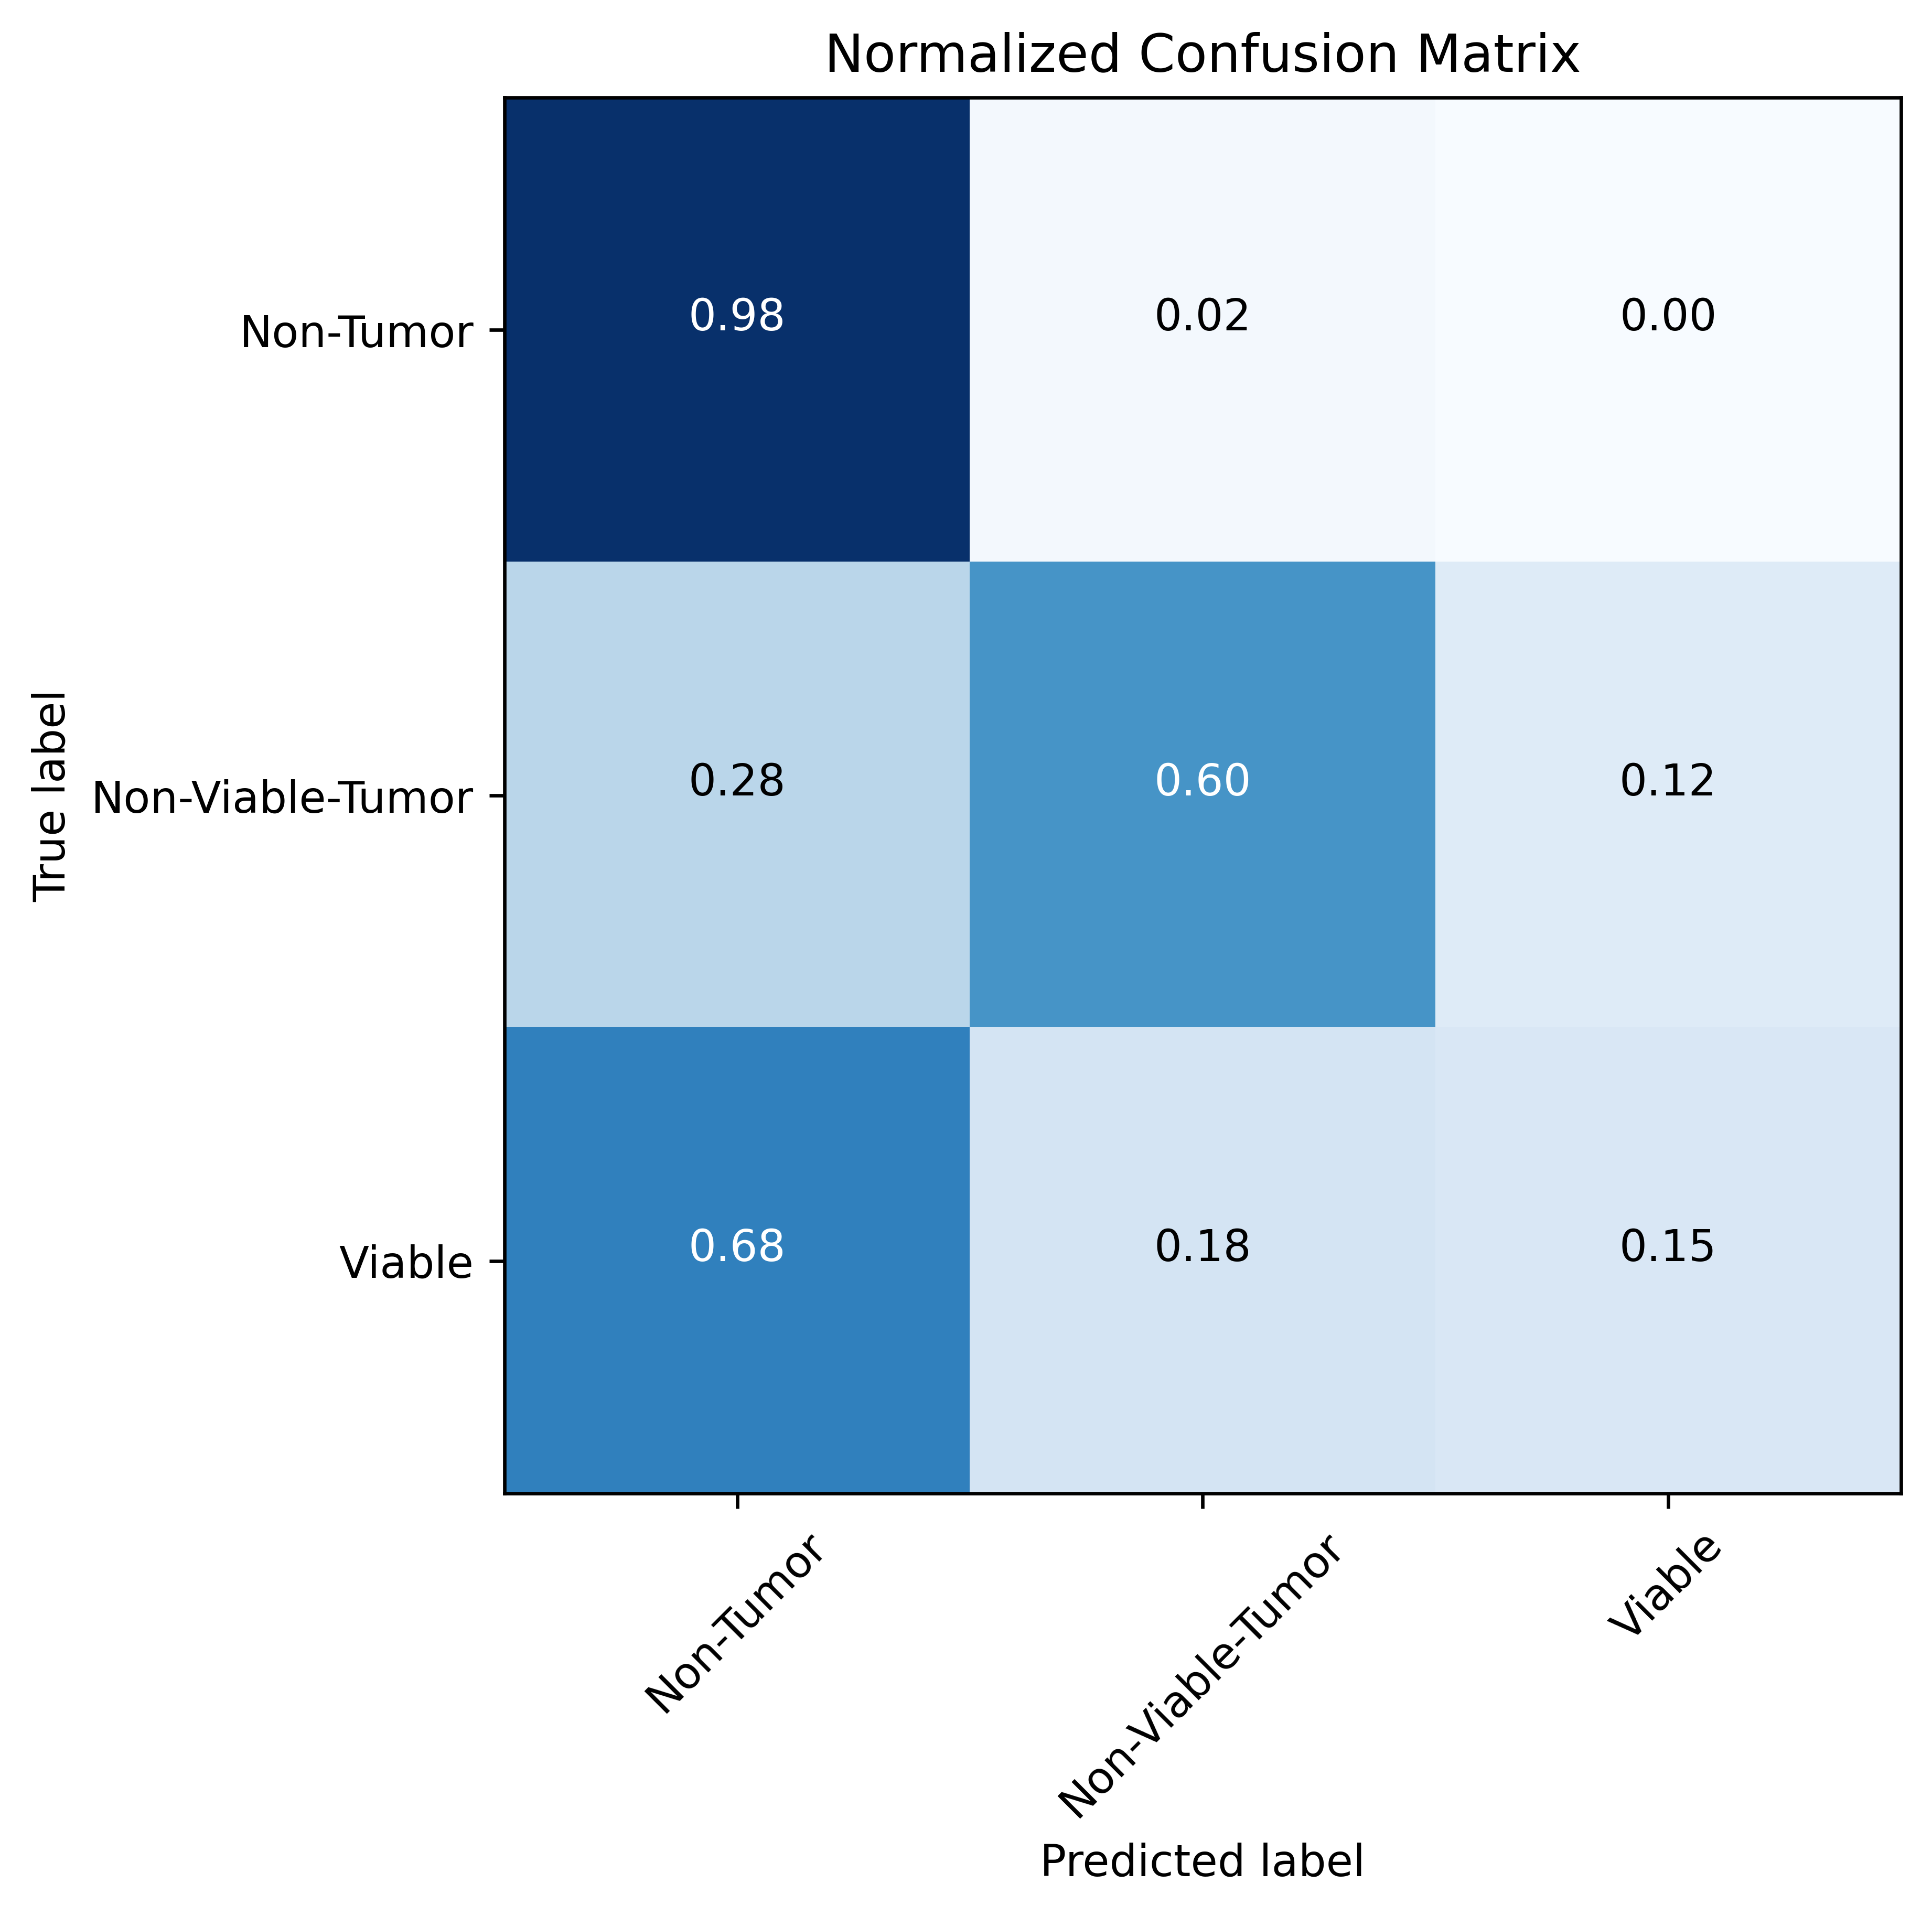

In [ ]:
# plotting confusion matrix with normalization
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**classification report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.61      0.98      0.76       104
           1       0.67      0.60      0.63        50
           2       0.65      0.15      0.24        74

    accuracy                           0.63       228
   macro avg       0.64      0.58      0.54       228
weighted avg       0.64      0.63      0.56       228



**calculating precision, recall(sensitivity), specificity by formula**

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, rf_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.614     	      0.829      	    0.39   
  1   Non-Viable-Tumor     0.667     	       0.3       	   0.883   
  2        Viable          0.647      	      0.122      	   0.957   


# Light Gradient Boosting (LGBM)

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# fit the model on the whole dataset
lgbm_model = LGBMClassifier(learning_rate= 0.005)

# fit our training data into lgbm classifier
lgbm_model.fit(x_train_features, y_train)

LGBMClassifier(learning_rate=0.005)

In [ ]:
# predicting test features using LGBM classifier
lgbm_pred = lgbm_model.predict(x_test_features)

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, lgbm_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.759


**Matthews Correlation Coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, lgbm_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.631


**ROC-AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, lgbm_model.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.935


**confusion matrix**

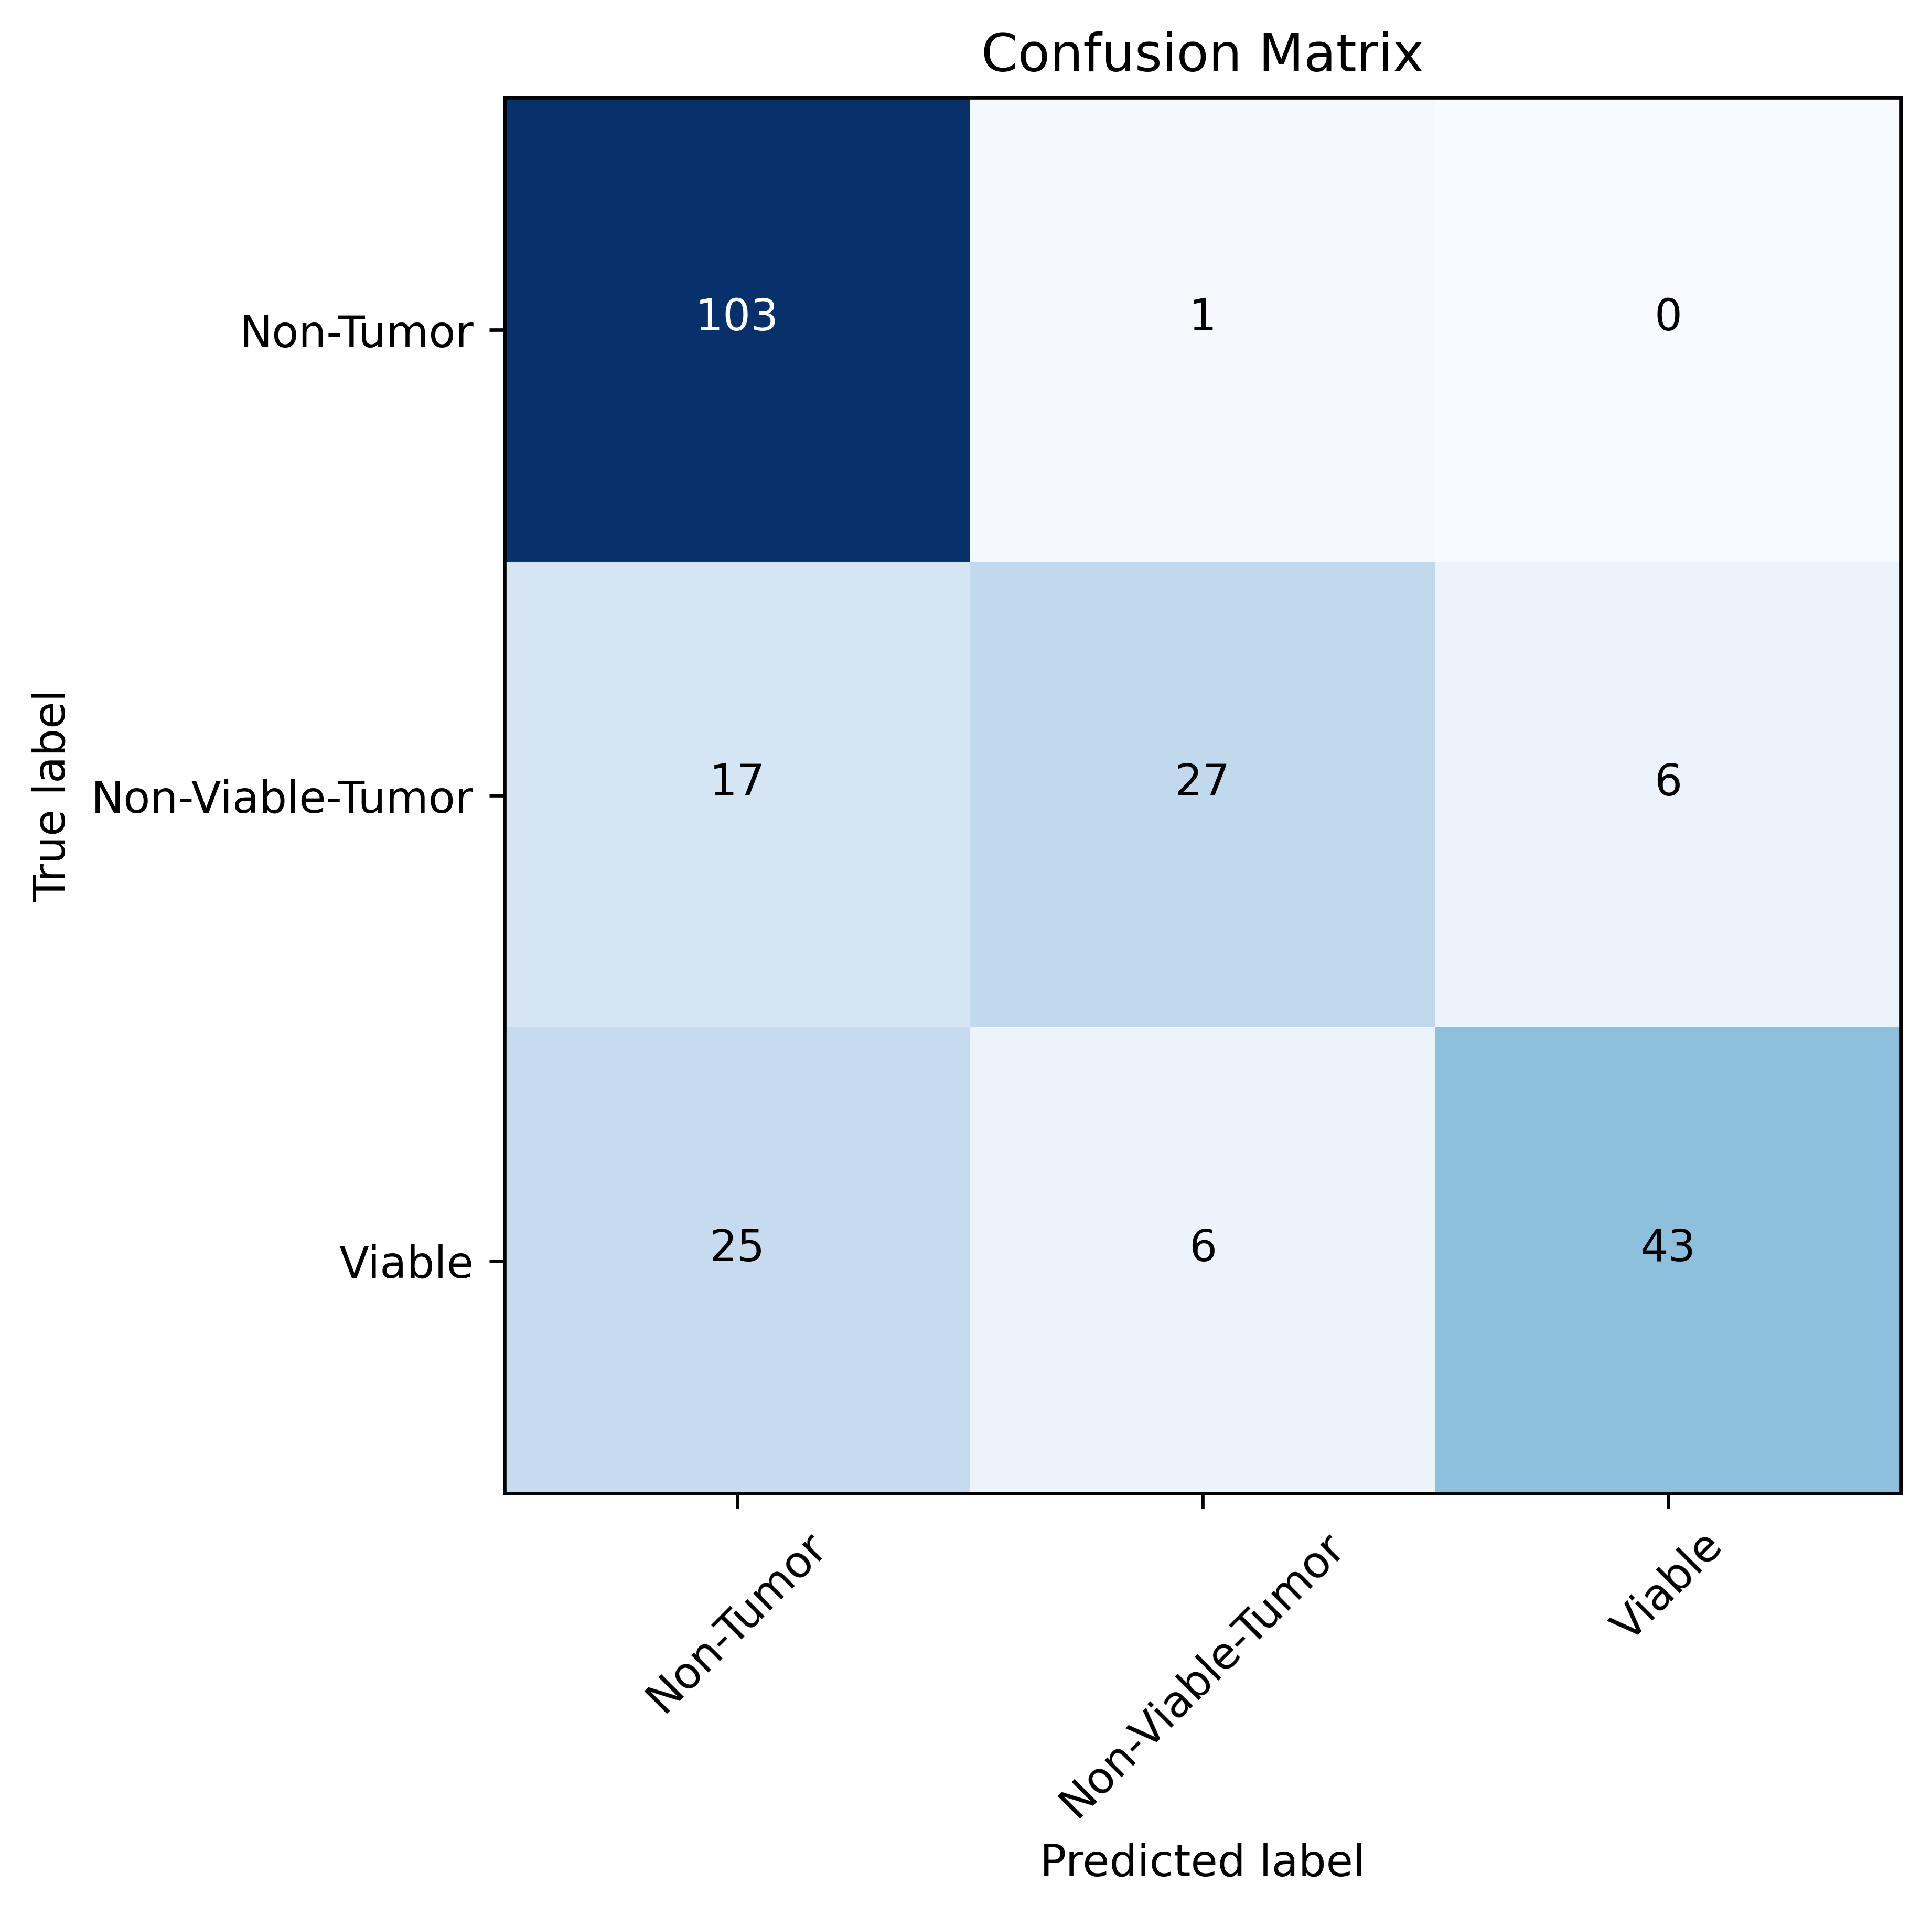

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, lgbm_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

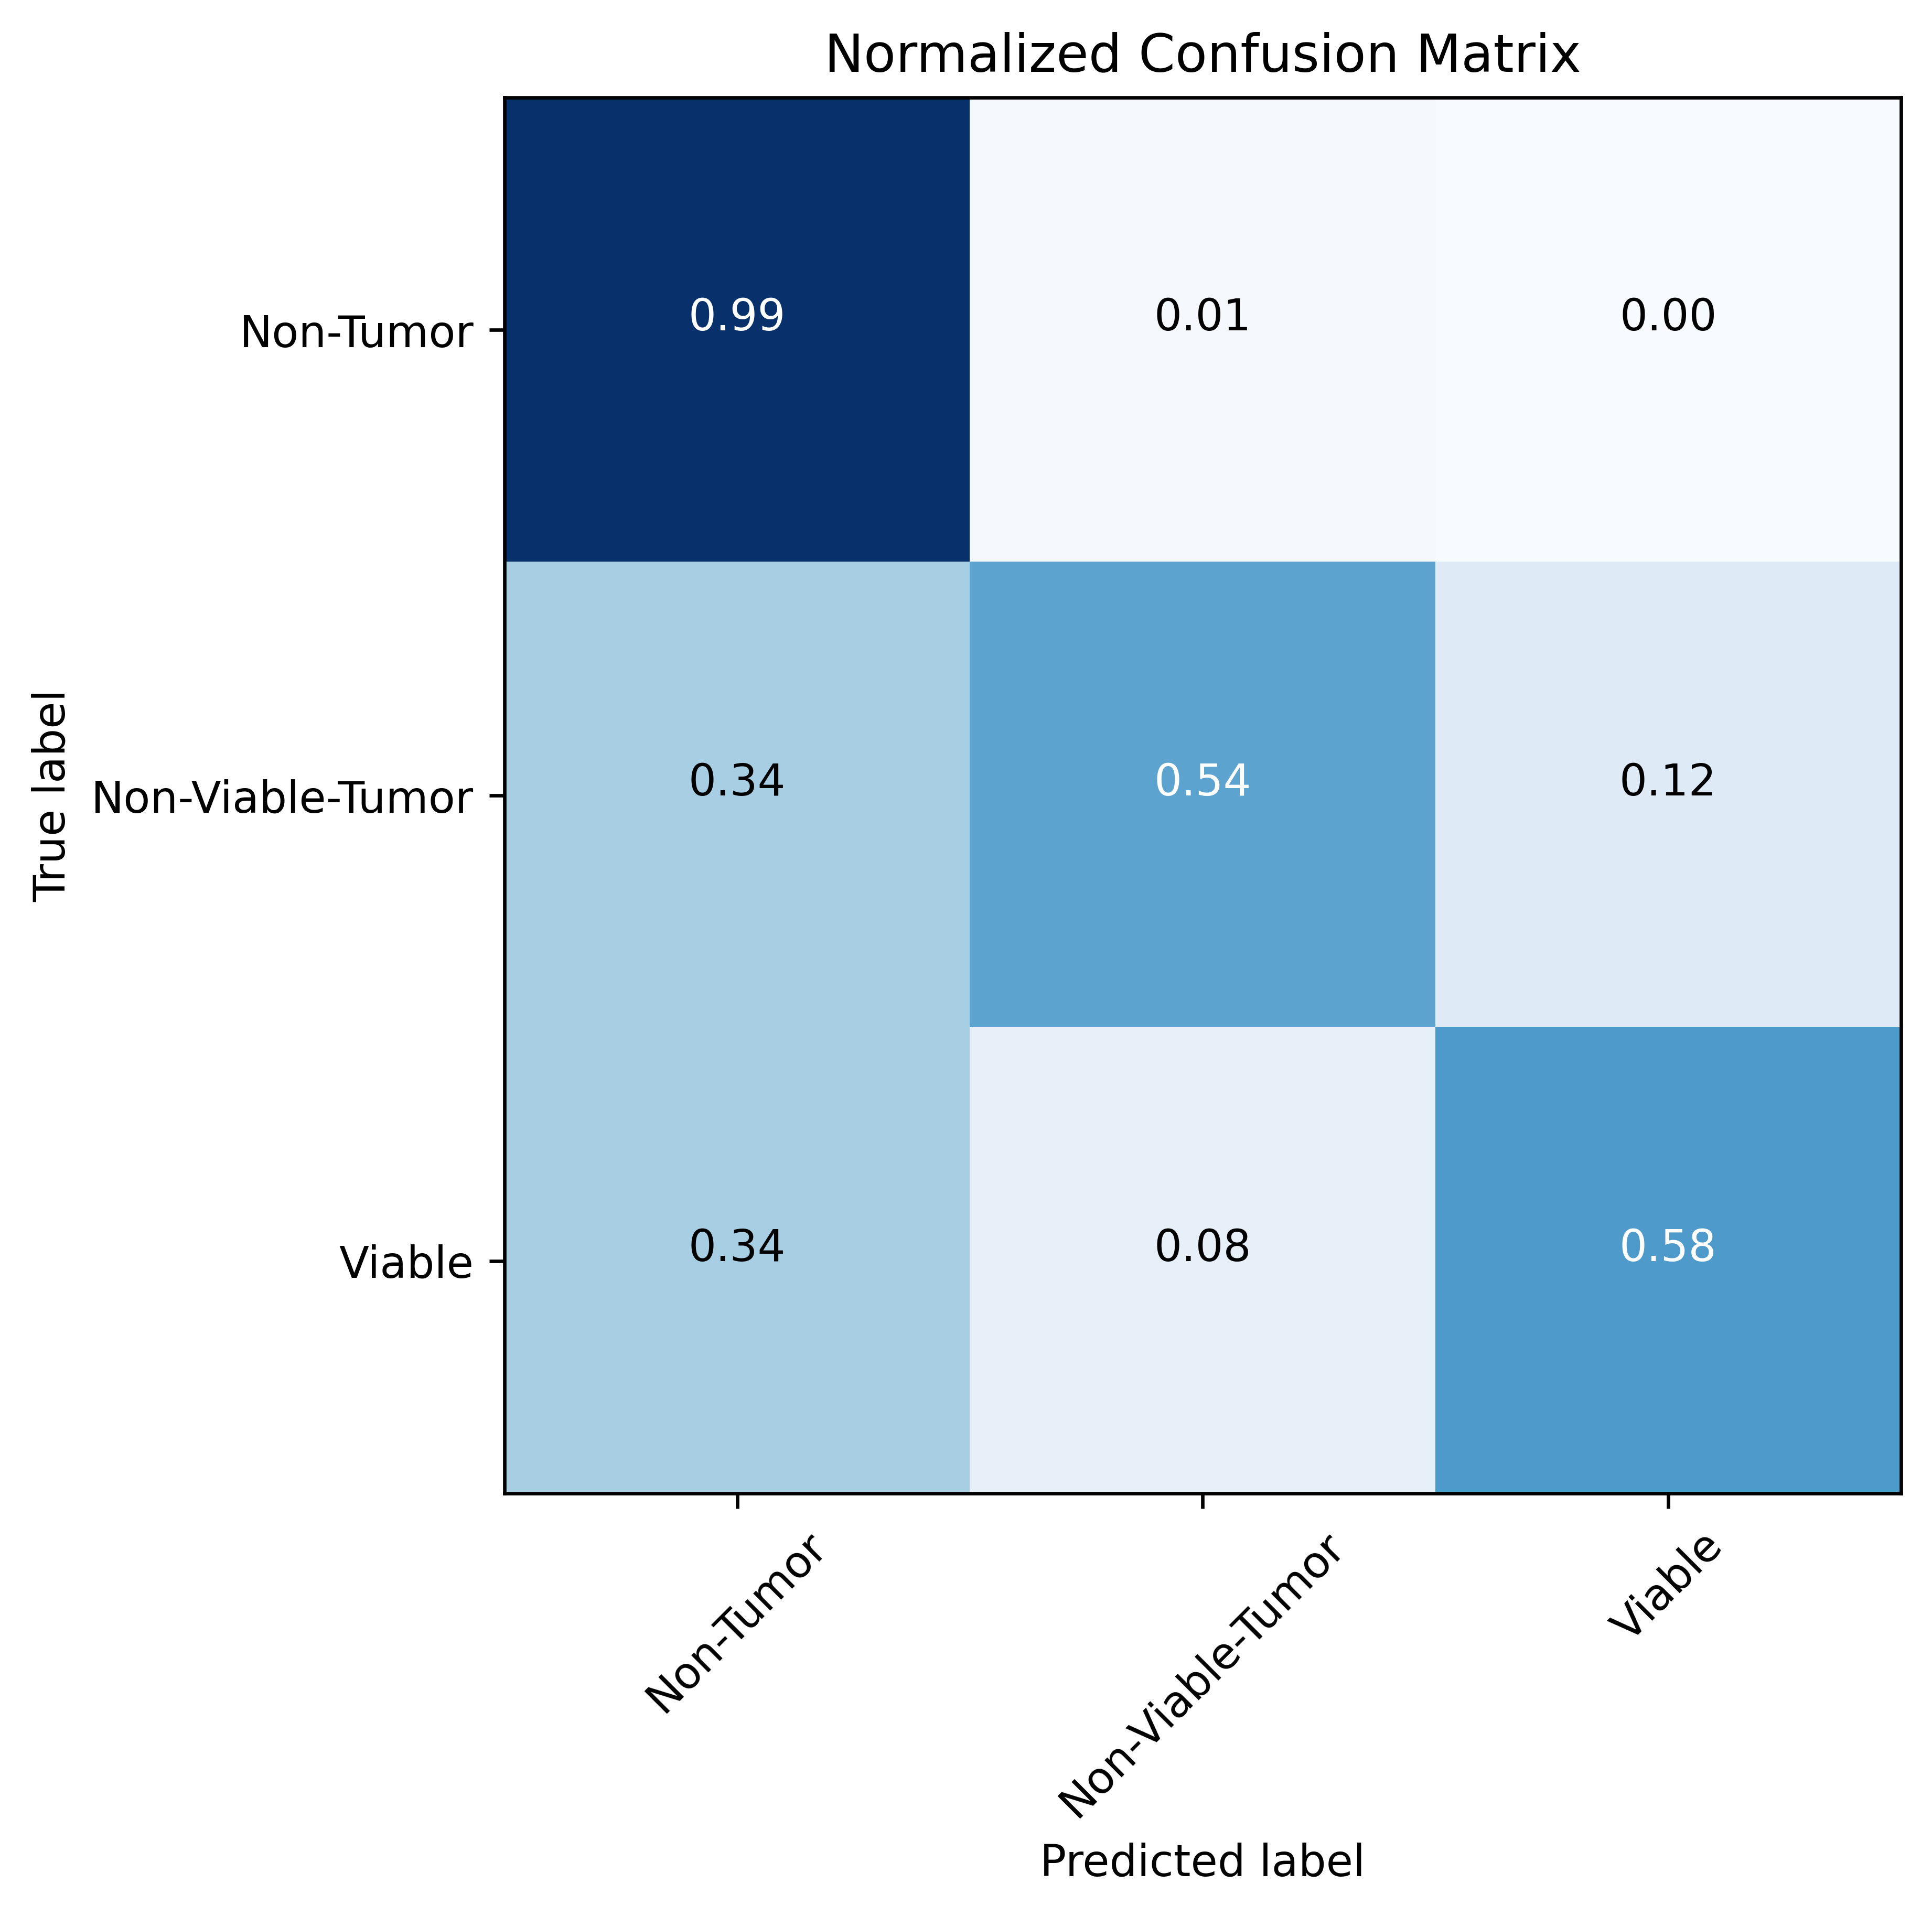

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**classsification report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       104
           1       0.79      0.54      0.64        50
           2       0.88      0.58      0.70        74

    accuracy                           0.76       228
   macro avg       0.79      0.70      0.72       228
weighted avg       0.78      0.76      0.75       228



**calculating precision, recall(sensitivity), specificity by formula**

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, lgbm_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.71     	      0.888      	   0.625   
  1   Non-Viable-Tumor     0.794     	       0.36      	   0.954   
  2        Viable          0.878      	      0.467      	   0.956   


# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(x_train_features, y_train)

MLPClassifier(random_state=1)

In [ ]:
# predicting through test data
mlp_pred = mlp_classifier.predict(x_test_features)

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.908


**Matthews correlation coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.855


**ROC AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.97


**confusion matrix**

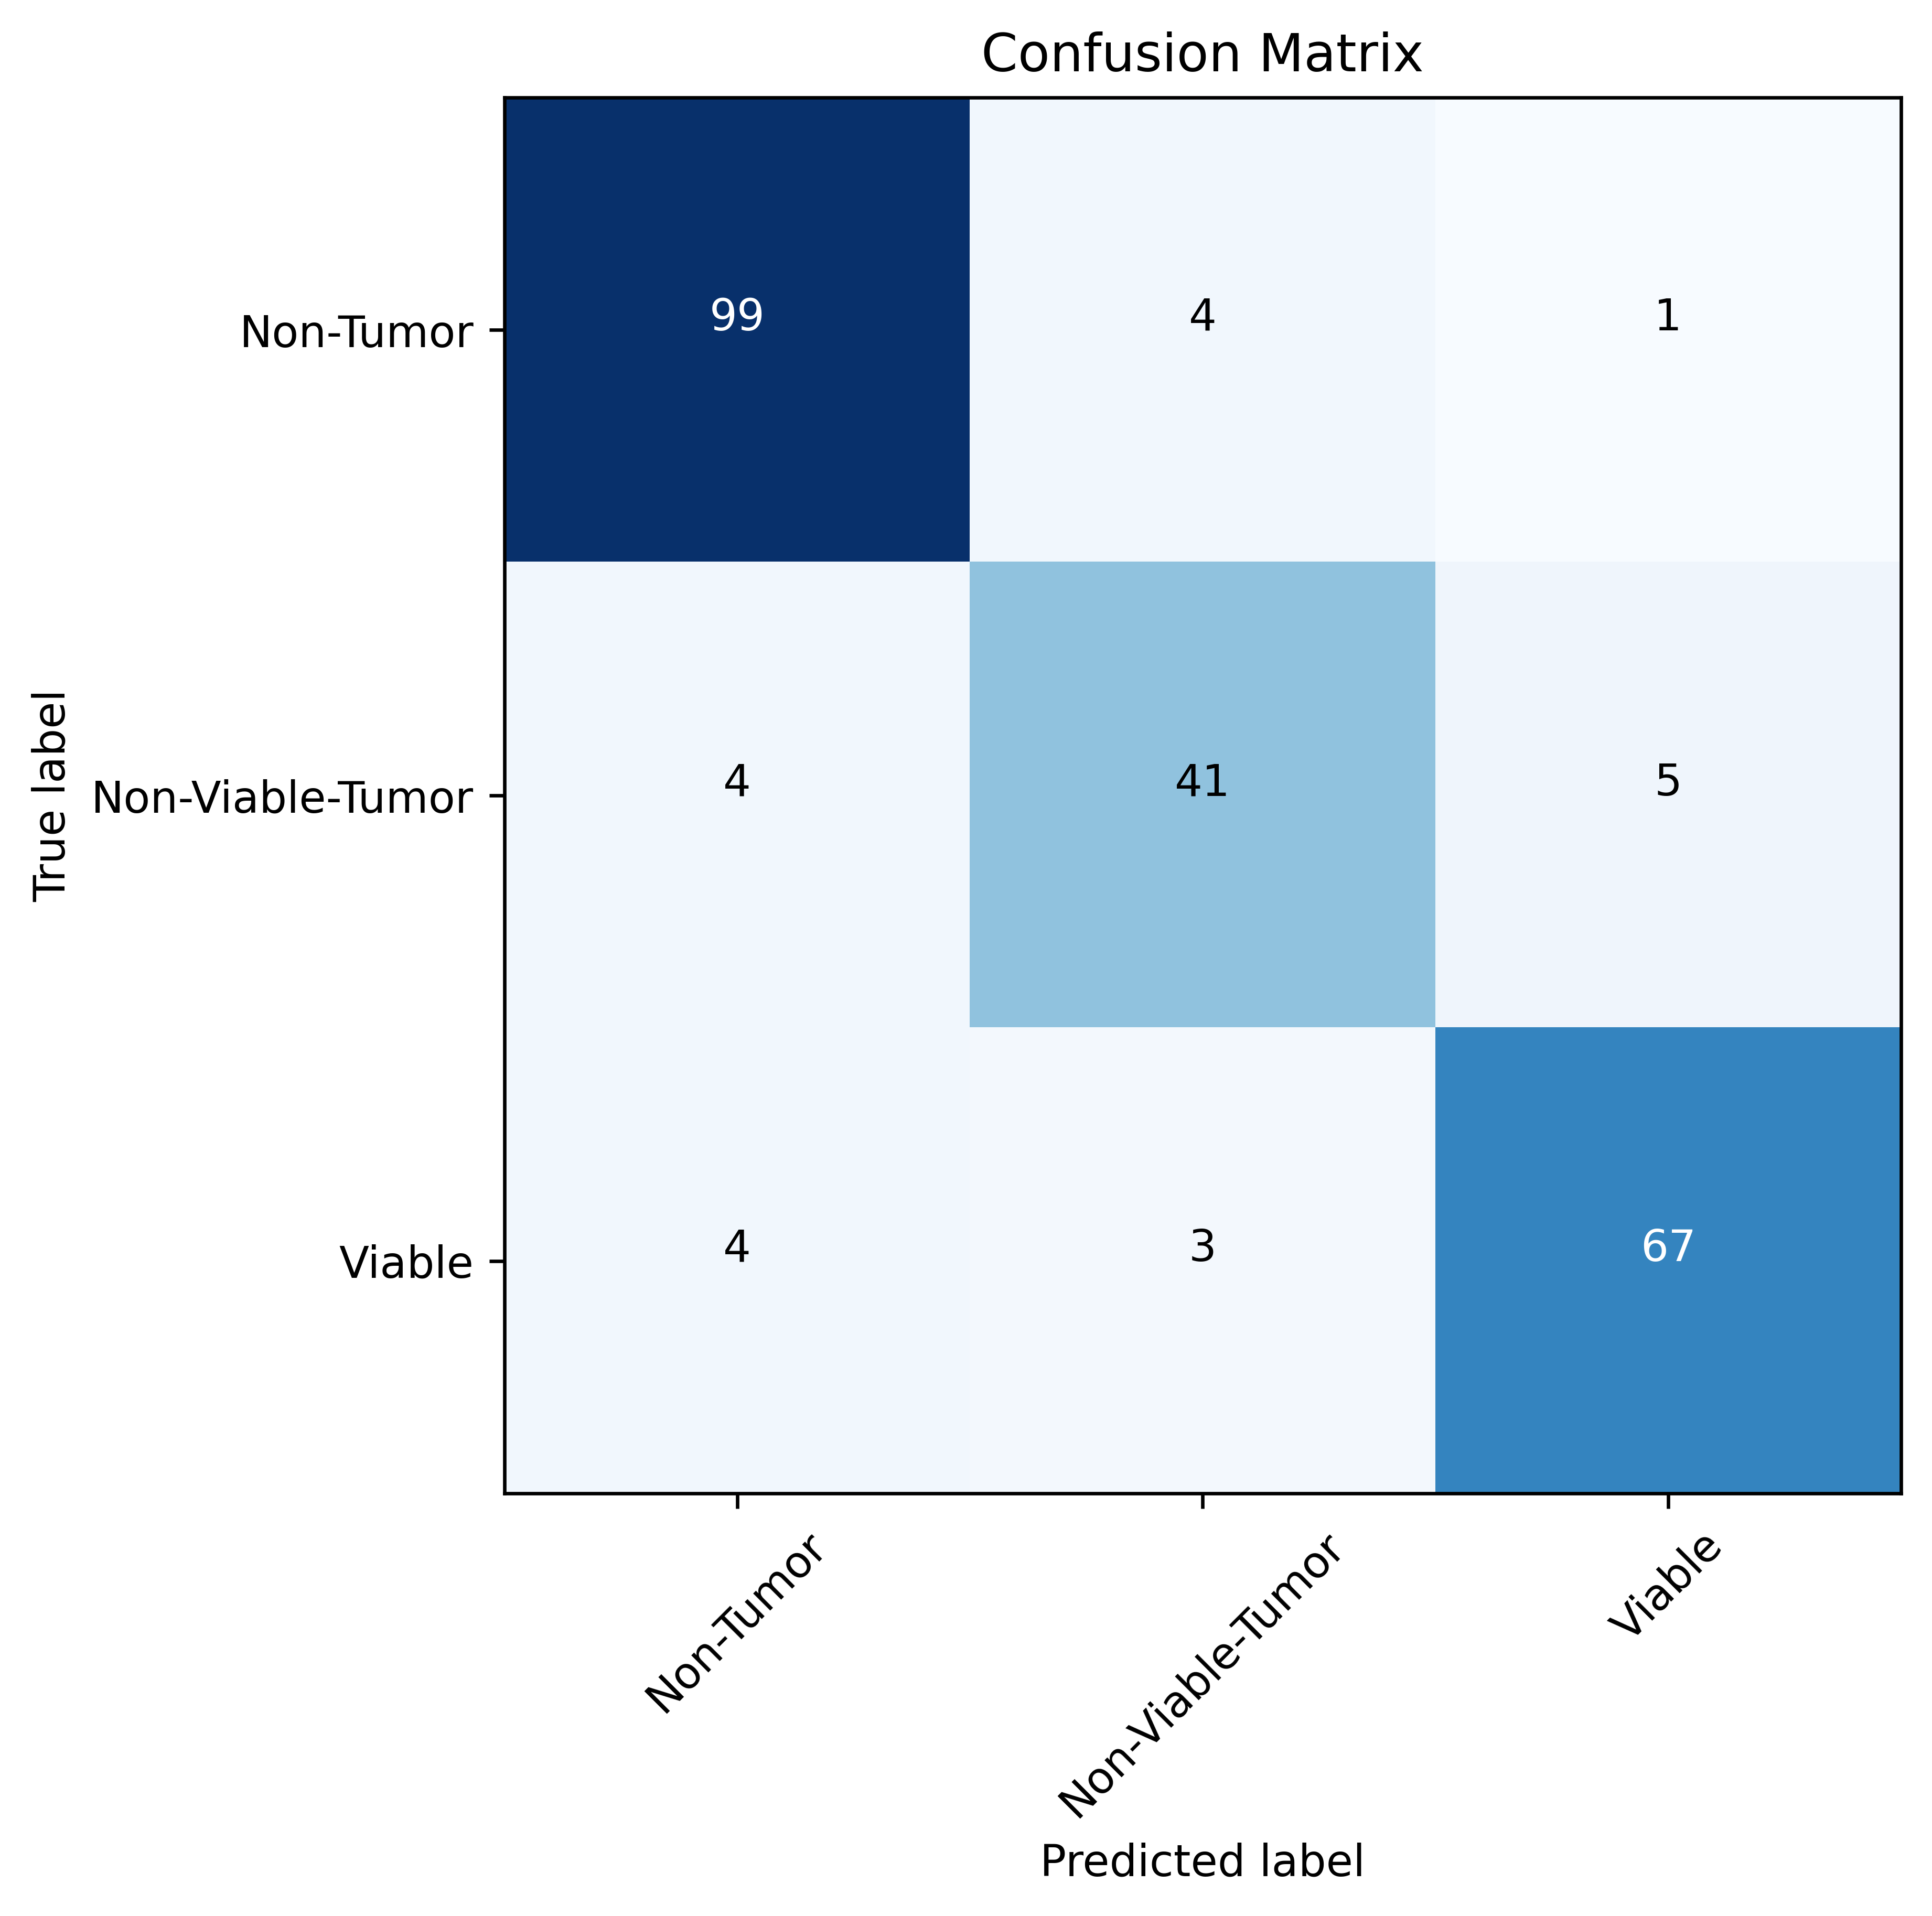

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, mlp_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

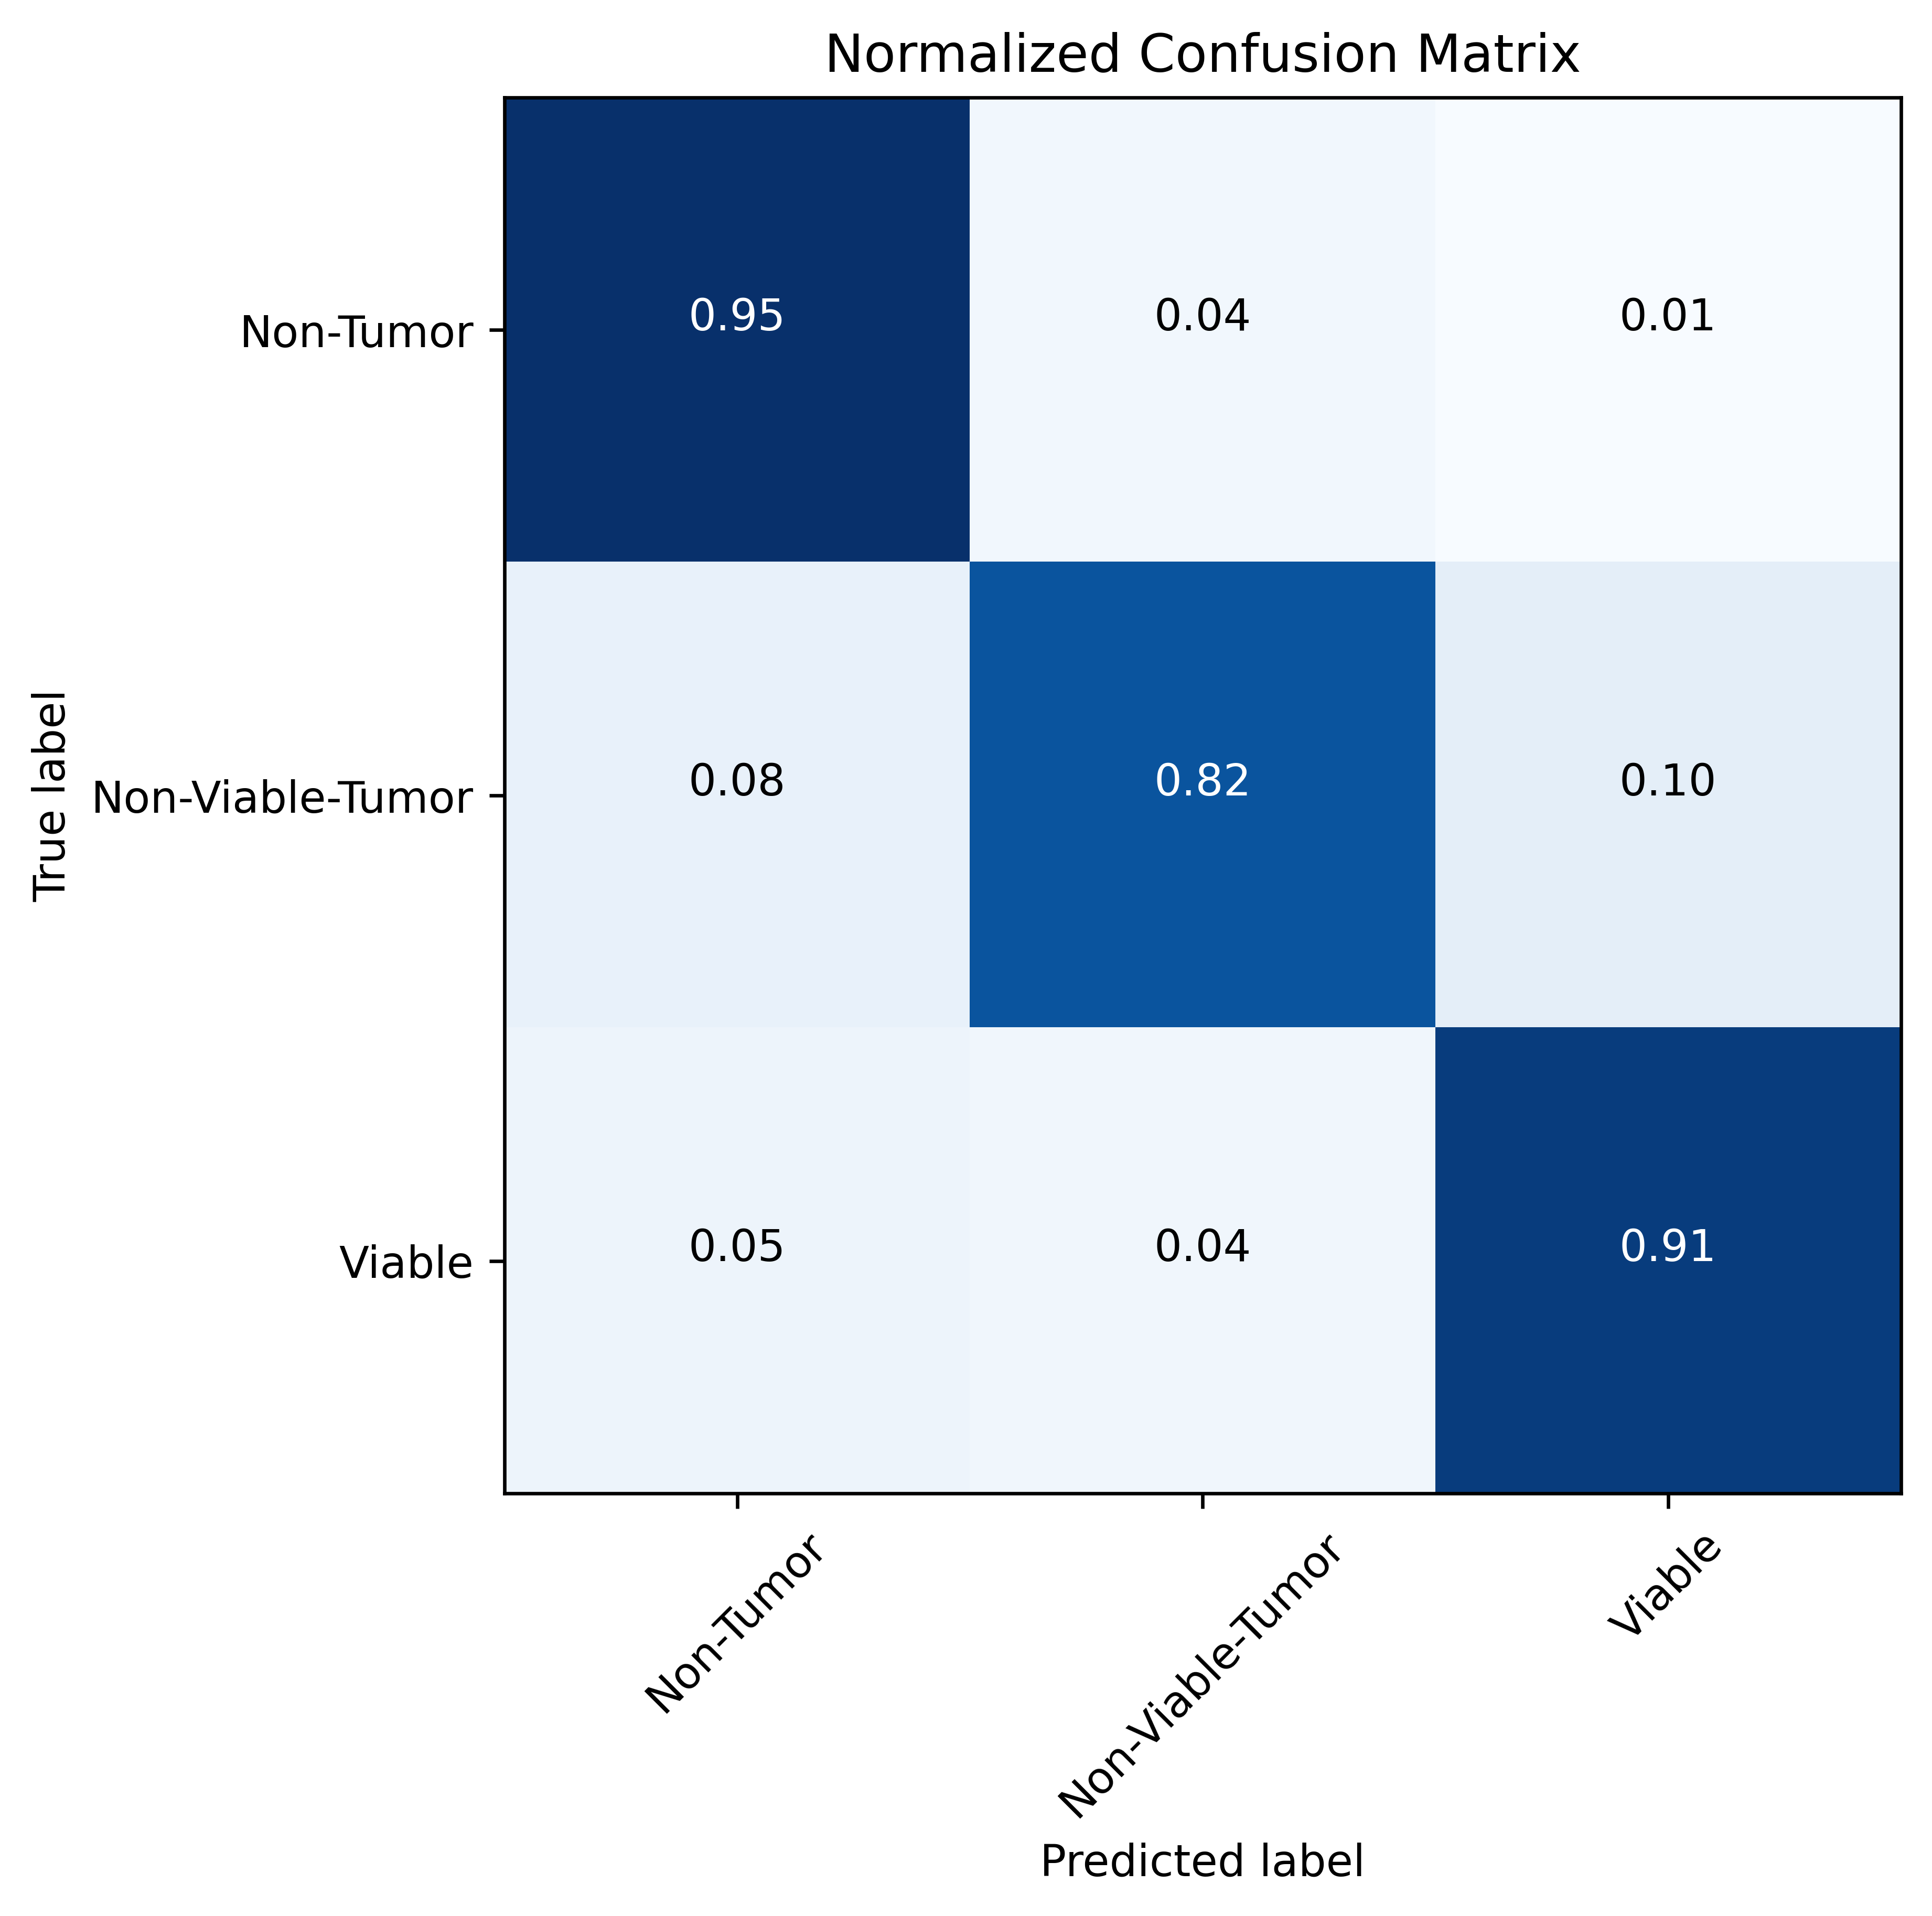

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**Classification report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       104
           1       0.85      0.82      0.84        50
           2       0.92      0.91      0.91        74

    accuracy                           0.91       228
   macro avg       0.90      0.89      0.90       228
weighted avg       0.91      0.91      0.91       228



**calculating precision, recall(sensitivity), specificity by formula**

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, mlp_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.925     	      0.884      	   0.931   
  1   Non-Viable-Tumor     0.854     	      0.745      	    0.96   
  2        Viable          0.918      	      0.817      	   0.959   


# Rough

In [ ]:
# Function to get TP, FP, TN, TP  for Binary class
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [ ]:
tp, fp, tn, fn = perf_measure(y_test, prediction)
print("True positive: ", tp)
print("False positive: ", fp)
print("True negative: ", tn)
print("False negative: ", fn)

True positive:  45
False positive:  1
True negative:  102
False negative:  10


In [ ]:
sensitivity  = tp / (tp+fn)
specificity  = tn / (tn+fp)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)

Sensitivity:  0.8181818181818182
Specificity:  0.9902912621359223


In [ ]:
# Precision = TruePositives / (TruePositives + FalsePositives)
prec = tp/(tp+fp)
print(prec)

0.9782608695652174


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(y_test, prediction,labels=[0,1,2])

In [ ]:
mcm

array([[[114,  10],
        [  2, 102]],

       [[167,   1],
        [ 15,  45]],

       [[154,  10],
        [  4,  60]]])

In [ ]:
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]

In [ ]:
print("True positive: ", tp)
print("False positive: ", fp)
print("True negative: ", tn)
print("False negative: ", fn)

True positive:  [102  45  60]
False positive:  [10  1 10]
True negative:  [114 167 154]
False negative:  [ 2 15  4]


In [ ]:
t_tp = tp.sum()
t_fp = fp.sum()
t_tn = tn.sum()
t_fn = fn.sum()

print("Total True positive: ", t_tp)
print("Total False positive: ", t_fp)
print("Total True negative: ", t_tn)
print("Total False negative: ", t_fn)

Total True positive:  207
Total False positive:  21
Total True negative:  435
Total False negative:  21


In [ ]:
# Precision = TruePositives / (TruePositives + FalsePositives)
prec = t_tp/(t_tp+t_fp)
print(prec)

0.9078947368421053


In [ ]:
n = mcm[0]
print(n)

[[114  10]
 [  2 102]]


In [ ]:
type(prediction)

numpy.ndarray

In [ ]:
data

,class,sensitivity,specificity
0,0,0.919355,0.980769
1,1,0.994048,0.750000
2,2,0.939024,0.937500
